<a href="https://colab.research.google.com/github/ccitChun/1081ML/blob/main/4LCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python --version
!nvidia-smi

Python 3.10.12
Wed Nov  6 03:13:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              46W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------

In [ ]:
!pip install thop

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from PIL import Image
import os
from torchvision import datasets
import numpy as np
from tqdm import tqdm
from google.colab import drive
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from thop import profile  # for calculating FLOPS and parameters


In [ ]:
drive.mount('/content/drive')
os.getcwd()
os.chdir("/content/drive/MyDrive") #更改路徑
os.listdir()
folders = os.listdir('./dataset6v2')
folders.sort()
data_path = '/content/drive/MyDrive/dataset6v2'
file_paths = []
labels = []

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Dataset class
class MyDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths# 存儲圖像文件路徑的列表
        self.labels = labels # 與圖像對應的標籤列表
        self.transform = transform # 可選的圖像變換（例如數據增強）

    def __len__(self):
        return len(self.file_paths) # 返回數據集中的圖像總數

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]  # 獲取索引為idx的圖像路徑
        image = Image.open(img_path).convert('RGB') # 打開圖像並確保它是RGB格式
        label = self.labels[idx] # 獲取相應的標籤

        if self.transform:
            image = self.transform(image) # 如果指定了轉換，則應用它

        return image, label # 返回圖像和標籤的元組

# Setup transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224),interpolation=Image.BILINEAR), # 將圖像大小調整為224x224像素
   # transforms.RandomHorizontalFlip(), # 隨機水平翻轉圖像（數據增強）
    transforms.ToTensor(), # 將圖像轉換為PyTorch張量
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # 歸一化圖像
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.BILINEAR),  # 同樣將圖像大小調整為224x224像素
    transforms.ToTensor(), # 將圖像轉換為PyTorch張量
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # 同樣歸一化圖像
])

In [ ]:
for folder_name in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder_name)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            file_paths.append(os.path.join(folder_path, file_name))
            labels.append(folder_name)

In [ ]:
# Define the lightweight CNN
class MultiScaleCNN(nn.Module):
    def __init__(self, num_classes):
        super(MultiScaleCNN, self).__init__()
        self.conv1_1x1 = nn.Conv2d(3, 10, kernel_size=1, padding='same')
        self.conv1_3x3 = nn.Conv2d(3, 10, kernel_size=3, padding='same')
        self.conv1_5x5 = nn.Conv2d(3, 10, kernel_size=5, padding='same')

        self.pool1 = nn.MaxPool2d(8)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(30 * 28 * 28, num_classes)

    def forward(self, x):
        x_1x1 = F.relu(self.conv1_1x1(x))
        x_3x3 = F.relu(self.conv1_3x3(x))
        x_5x5 = F.relu(self.conv1_5x5(x))
        # 将不同尺度的卷积结果进行拼接（在通道维度上合并）
        x = torch.cat((x_1x1, x_3x3, x_5x5), dim=1)

        x = self.pool1(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc1(x)
        return x

In [ ]:
# Convert labels to numerical values
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
labels = [label_to_index[label] for label in labels]

In [ ]:
# Split data
train_files, test_files, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.2, random_state=42)

train_dataset = MyDataset(train_files, train_labels, transform=train_transform)
test_dataset = MyDataset(test_files, test_labels, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiScaleCNN(num_classes=len(label_to_index)).to(device)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Function to calculate performance metrics
def calculate_metrics(y_true, y_pred, y_prob):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    auc = roc_auc_score(y_true, y_prob, multi_class='ovr', average='weighted')
    return precision, recall, f1, auc

In [ ]:
# Training and evaluation function
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    model.to(device)
    input_tensor = torch.randn(1, 3, 224, 224).to(device)
    flops, params = profile(model, inputs=(input_tensor,))
    flops_m = flops / 10**6
    params_m = params / 10**6
    print(f'FLOPS: {flops_m:.6f} MFLOPs, Parameters: {params_m:.6f} M')

    for epoch in range(num_epochs):
        model.train()
        total_loss, total_correct = 0, 0
        y_true, y_pred, y_prob = [], [], []

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_correct += (outputs.argmax(1) == labels).sum().item()

            y_true.extend(labels.cpu().detach().numpy())
            y_pred.extend(outputs.argmax(1).cpu().detach().numpy())
            y_prob.extend(F.softmax(outputs, dim=1).cpu().detach().numpy())  # 獲取概率

        train_loss = total_loss / len(train_loader.dataset)
        train_accuracy = total_correct / len(train_loader.dataset)
        train_precision, train_recall, train_f1, train_auc = calculate_metrics(y_true, y_pred, y_prob)

        model.eval()
        total_loss, total_correct = 0, 0
        y_true, y_pred, y_prob = [], [], []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                total_correct += (outputs.argmax(1) == labels).sum().item()

                y_true.extend(labels.cpu().detach().numpy())
                y_pred.extend(outputs.argmax(1).cpu().detach().numpy())
                y_prob.extend(F.softmax(outputs, dim=1).cpu().detach().numpy())  # 獲取概率

        test_loss = total_loss / len(test_loader.dataset)
        test_accuracy = total_correct / len(test_loader.dataset)
        test_precision, test_recall, test_f1, test_auc = calculate_metrics(y_true, y_pred, y_prob)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, '
              f'Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, '
              f'Test F1: {test_f1:.4f}, Test AUC: {test_auc:.4f}')

        # 混淆矩陣
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_to_index.keys(), yticklabels=label_to_index.keys())
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(f'Confusion Matrix for Epoch {epoch+1}')
        plt.show()

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPS: 52.825920 MFLOPs, Parameters: 0.142206 M


100%|██████████| 122/122 [12:06<00:00,  5.95s/it]


Epoch 1/50, Train Loss: 0.0533, Train Accuracy: 0.6659, Test Loss: 0.0233, Test Accuracy: 0.7515, Test Precision: 0.8340, Test Recall: 0.7515, Test F1: 0.7309, Test AUC: 0.9702


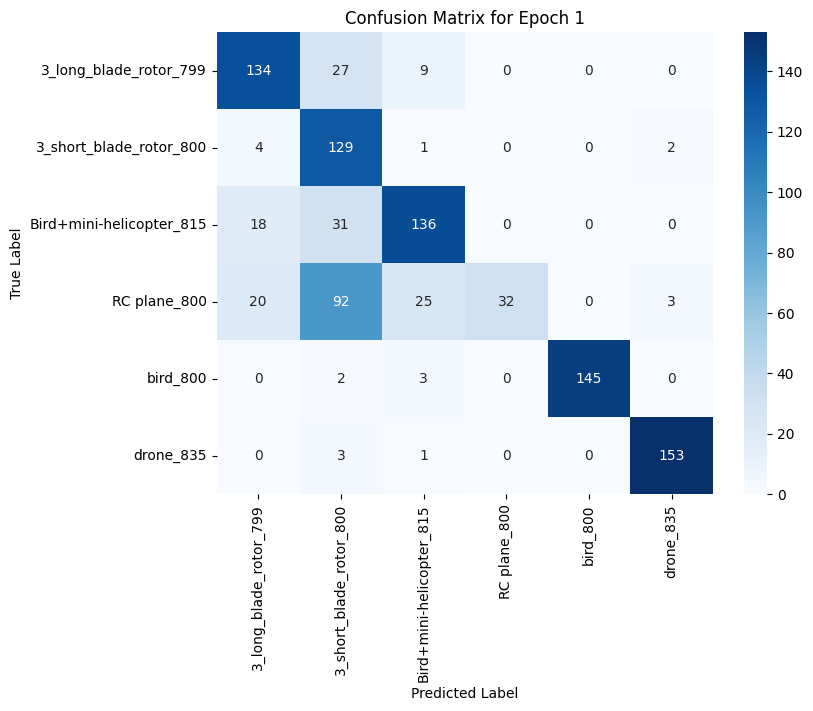

100%|██████████| 122/122 [01:08<00:00,  1.77it/s]


Epoch 2/50, Train Loss: 0.0151, Train Accuracy: 0.8368, Test Loss: 0.0126, Test Accuracy: 0.8567, Test Precision: 0.8851, Test Recall: 0.8567, Test F1: 0.8559, Test AUC: 0.9856


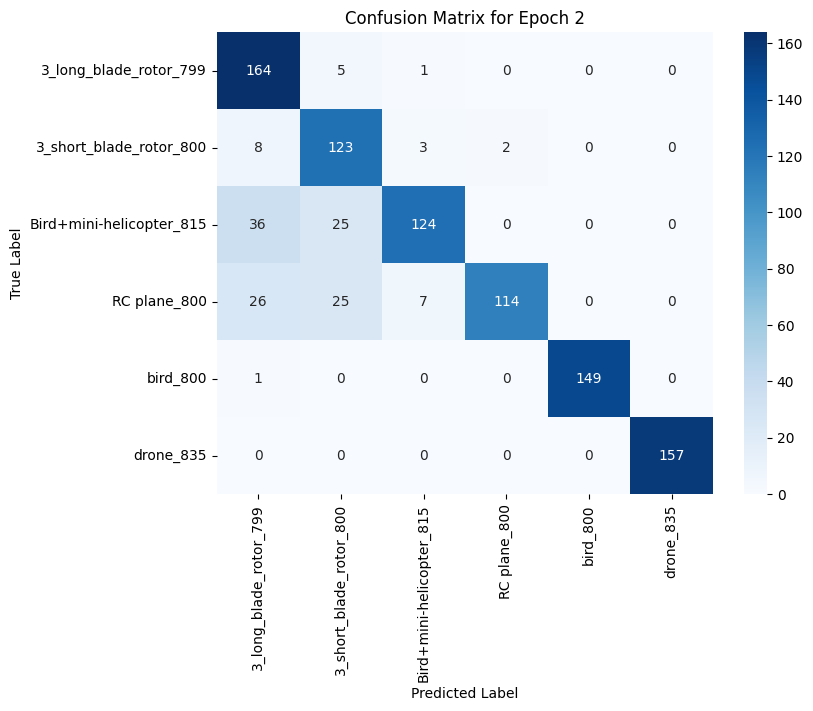

100%|██████████| 122/122 [01:08<00:00,  1.78it/s]


Epoch 3/50, Train Loss: 0.0118, Train Accuracy: 0.8701, Test Loss: 0.0163, Test Accuracy: 0.8371, Test Precision: 0.8771, Test Recall: 0.8371, Test F1: 0.8303, Test AUC: 0.9901


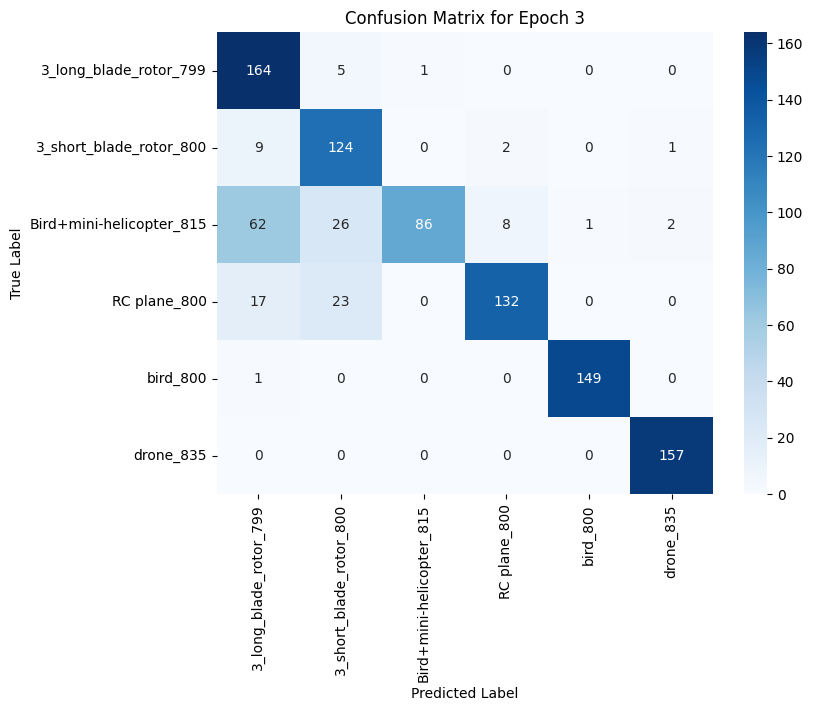

100%|██████████| 122/122 [01:08<00:00,  1.79it/s]


Epoch 4/50, Train Loss: 0.0120, Train Accuracy: 0.8765, Test Loss: 0.0103, Test Accuracy: 0.9052, Test Precision: 0.9144, Test Recall: 0.9052, Test F1: 0.9016, Test AUC: 0.9926


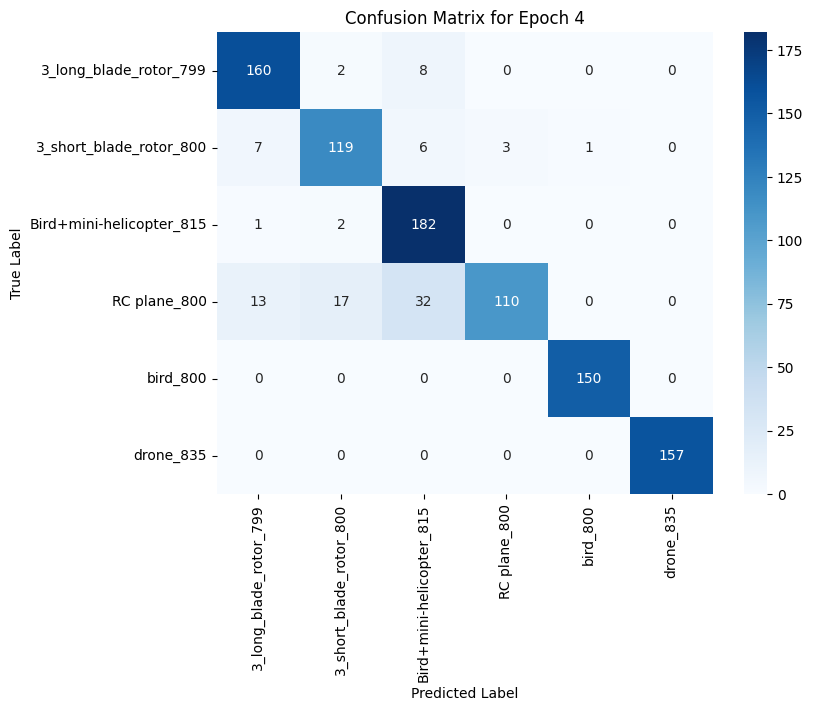

100%|██████████| 122/122 [01:08<00:00,  1.78it/s]


Epoch 5/50, Train Loss: 0.0085, Train Accuracy: 0.9090, Test Loss: 0.0059, Test Accuracy: 0.9495, Test Precision: 0.9505, Test Recall: 0.9495, Test F1: 0.9496, Test AUC: 0.9952


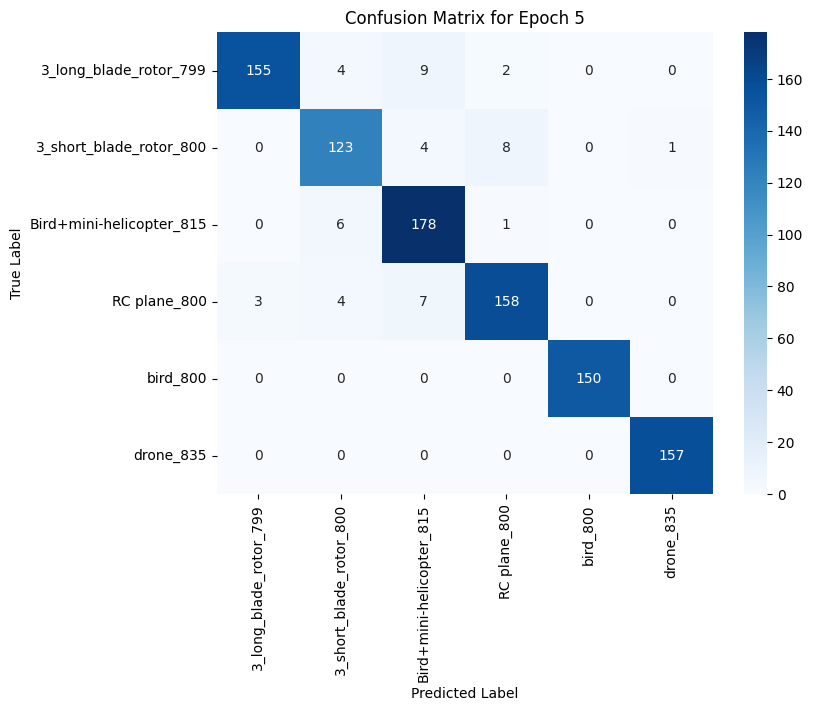

100%|██████████| 122/122 [01:08<00:00,  1.78it/s]


Epoch 6/50, Train Loss: 0.0099, Train Accuracy: 0.9036, Test Loss: 0.0104, Test Accuracy: 0.8979, Test Precision: 0.9147, Test Recall: 0.8979, Test F1: 0.8999, Test AUC: 0.9926


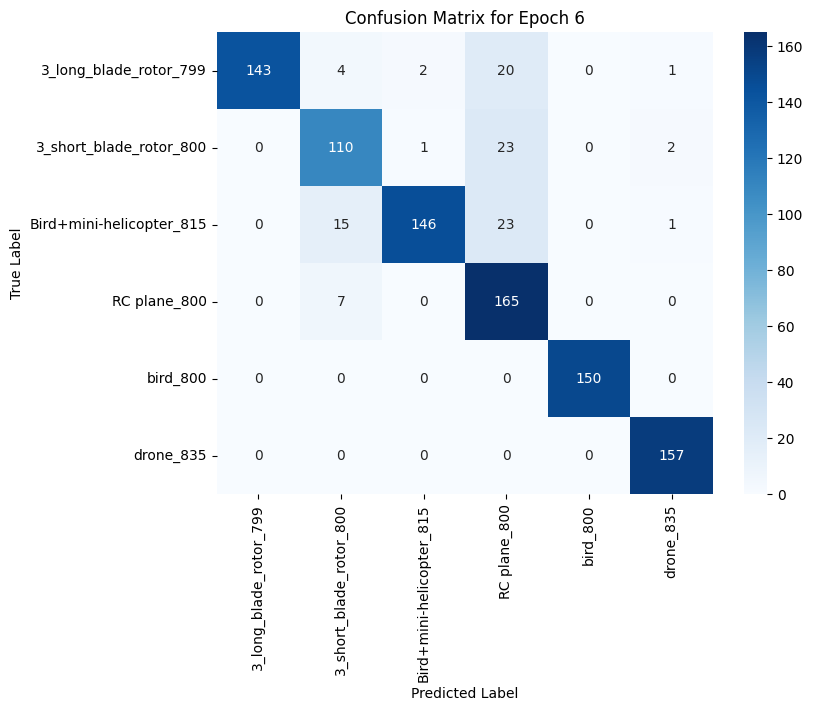

100%|██████████| 122/122 [01:08<00:00,  1.78it/s]


Epoch 7/50, Train Loss: 0.0102, Train Accuracy: 0.9134, Test Loss: 0.0087, Test Accuracy: 0.9103, Test Precision: 0.9279, Test Recall: 0.9103, Test F1: 0.9082, Test AUC: 0.9956


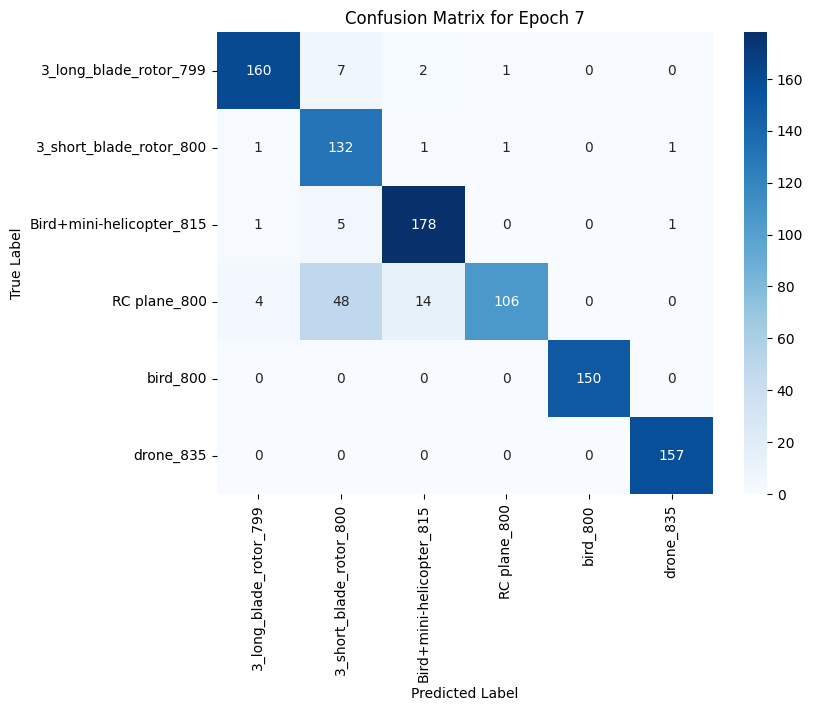

100%|██████████| 122/122 [01:08<00:00,  1.78it/s]


Epoch 8/50, Train Loss: 0.0059, Train Accuracy: 0.9376, Test Loss: 0.0074, Test Accuracy: 0.9196, Test Precision: 0.9342, Test Recall: 0.9196, Test F1: 0.9209, Test AUC: 0.9967


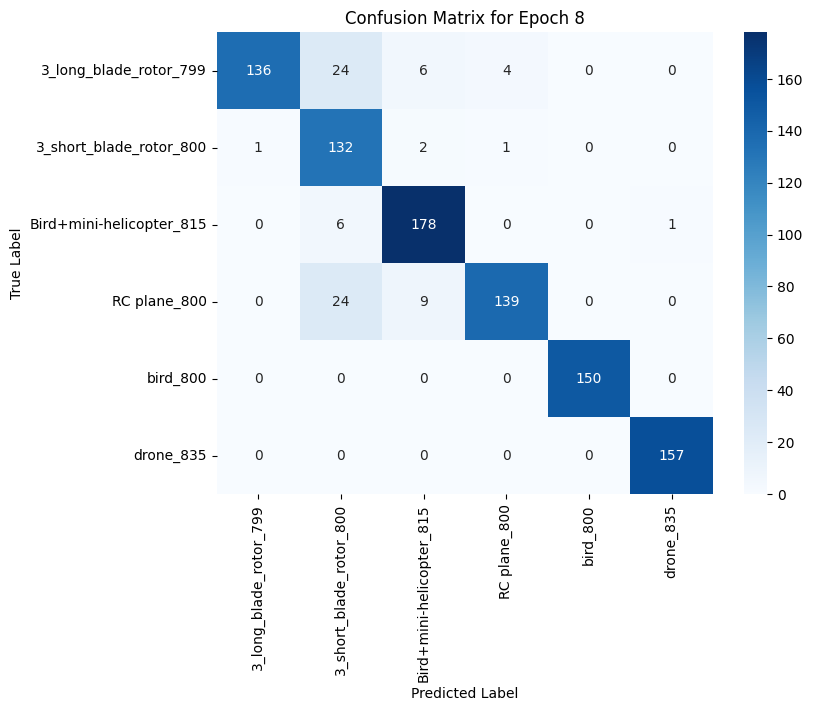

100%|██████████| 122/122 [01:09<00:00,  1.75it/s]


Epoch 9/50, Train Loss: 0.0053, Train Accuracy: 0.9441, Test Loss: 0.0059, Test Accuracy: 0.9320, Test Precision: 0.9382, Test Recall: 0.9320, Test F1: 0.9315, Test AUC: 0.9974


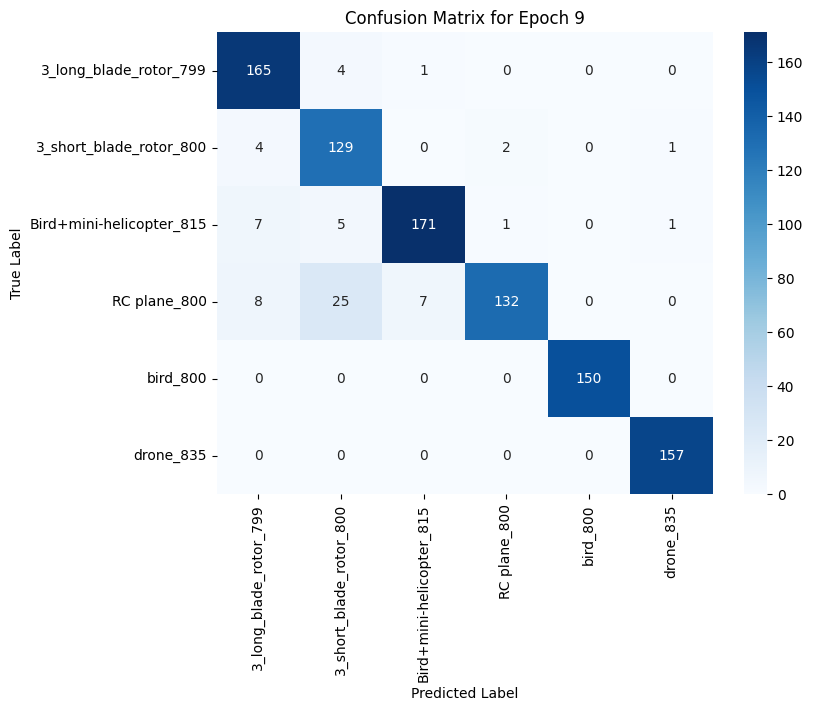

100%|██████████| 122/122 [01:10<00:00,  1.74it/s]


Epoch 10/50, Train Loss: 0.0053, Train Accuracy: 0.9415, Test Loss: 0.0066, Test Accuracy: 0.9258, Test Precision: 0.9329, Test Recall: 0.9258, Test F1: 0.9252, Test AUC: 0.9970


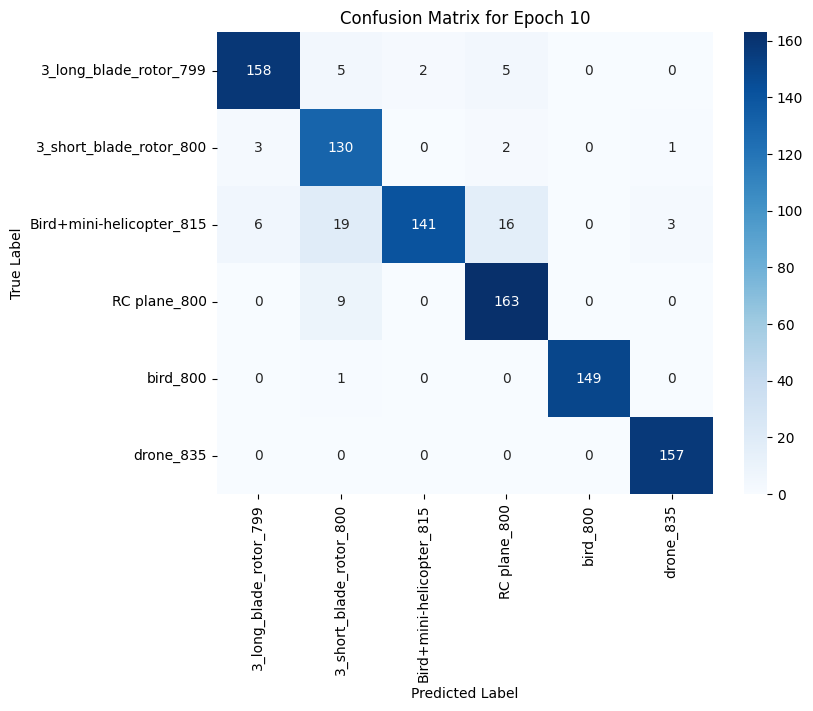

100%|██████████| 122/122 [01:09<00:00,  1.76it/s]


Epoch 11/50, Train Loss: 0.0044, Train Accuracy: 0.9518, Test Loss: 0.0049, Test Accuracy: 0.9474, Test Precision: 0.9496, Test Recall: 0.9474, Test F1: 0.9474, Test AUC: 0.9977


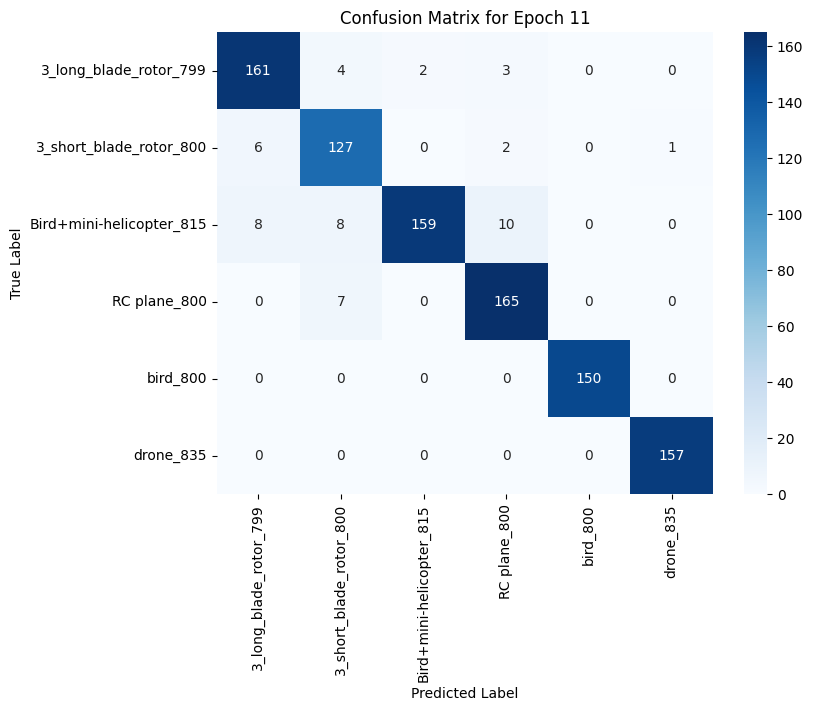

100%|██████████| 122/122 [01:08<00:00,  1.77it/s]


Epoch 12/50, Train Loss: 0.0044, Train Accuracy: 0.9472, Test Loss: 0.0068, Test Accuracy: 0.9371, Test Precision: 0.9425, Test Recall: 0.9371, Test F1: 0.9382, Test AUC: 0.9952


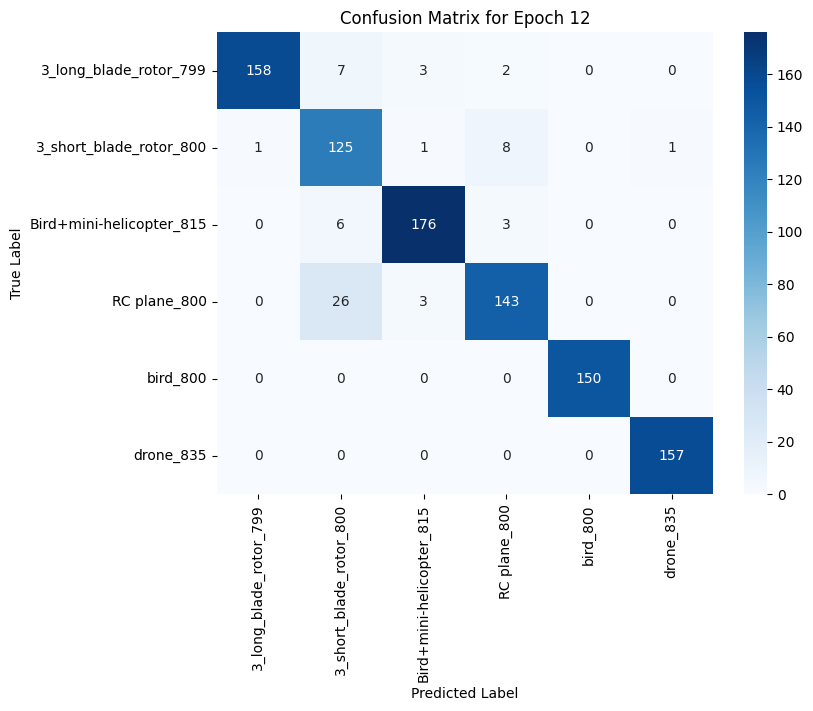

100%|██████████| 122/122 [01:08<00:00,  1.77it/s]


Epoch 13/50, Train Loss: 0.0064, Train Accuracy: 0.9366, Test Loss: 0.0057, Test Accuracy: 0.9454, Test Precision: 0.9486, Test Recall: 0.9454, Test F1: 0.9451, Test AUC: 0.9979


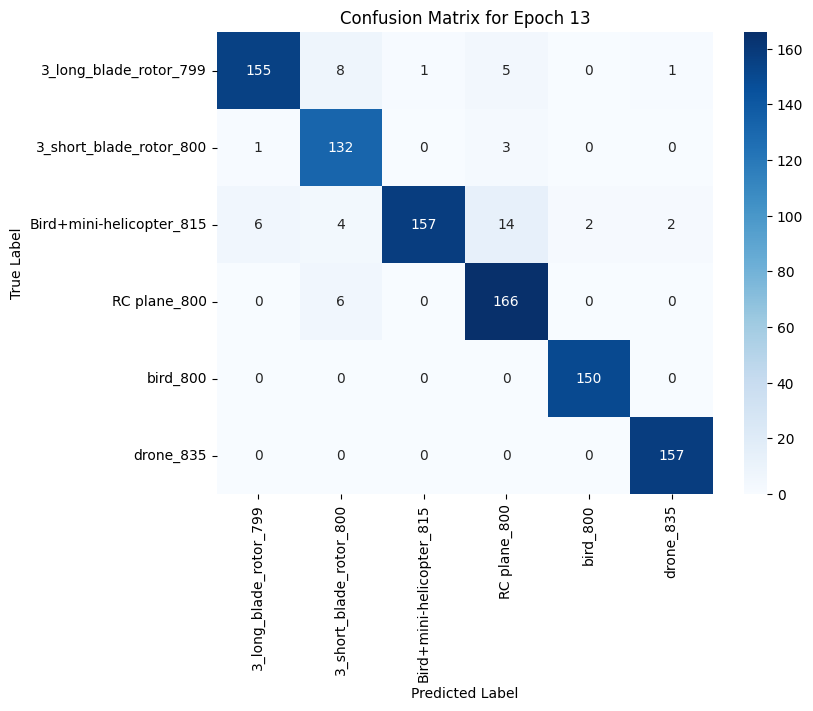

100%|██████████| 122/122 [01:10<00:00,  1.74it/s]


Epoch 14/50, Train Loss: 0.0054, Train Accuracy: 0.9438, Test Loss: 0.0044, Test Accuracy: 0.9557, Test Precision: 0.9563, Test Recall: 0.9557, Test F1: 0.9558, Test AUC: 0.9978


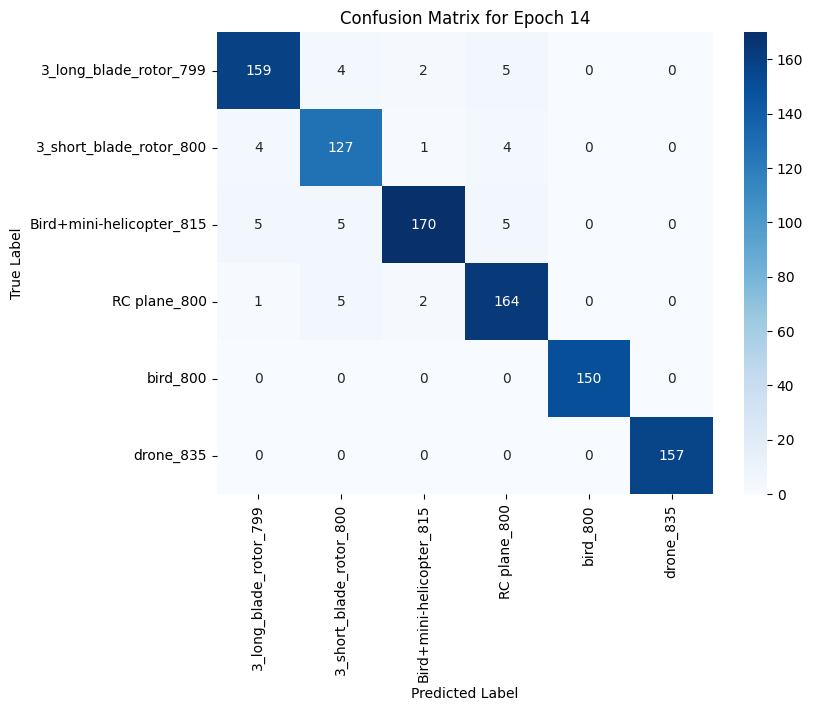

100%|██████████| 122/122 [01:09<00:00,  1.76it/s]


Epoch 15/50, Train Loss: 0.0038, Train Accuracy: 0.9629, Test Loss: 0.0052, Test Accuracy: 0.9526, Test Precision: 0.9556, Test Recall: 0.9526, Test F1: 0.9527, Test AUC: 0.9981


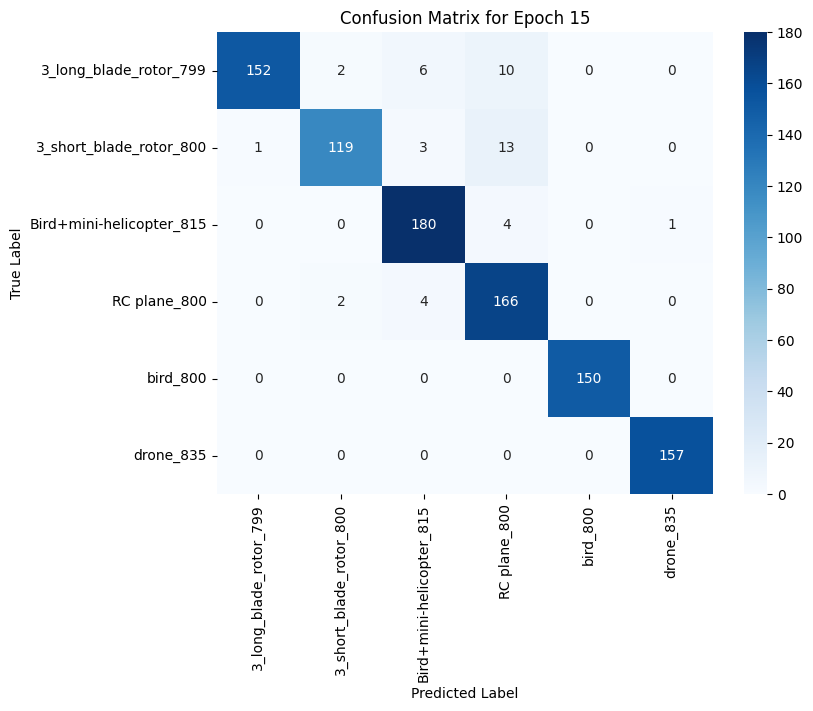

100%|██████████| 122/122 [01:09<00:00,  1.76it/s]


Epoch 16/50, Train Loss: 0.0033, Train Accuracy: 0.9634, Test Loss: 0.0038, Test Accuracy: 0.9619, Test Precision: 0.9631, Test Recall: 0.9619, Test F1: 0.9621, Test AUC: 0.9986


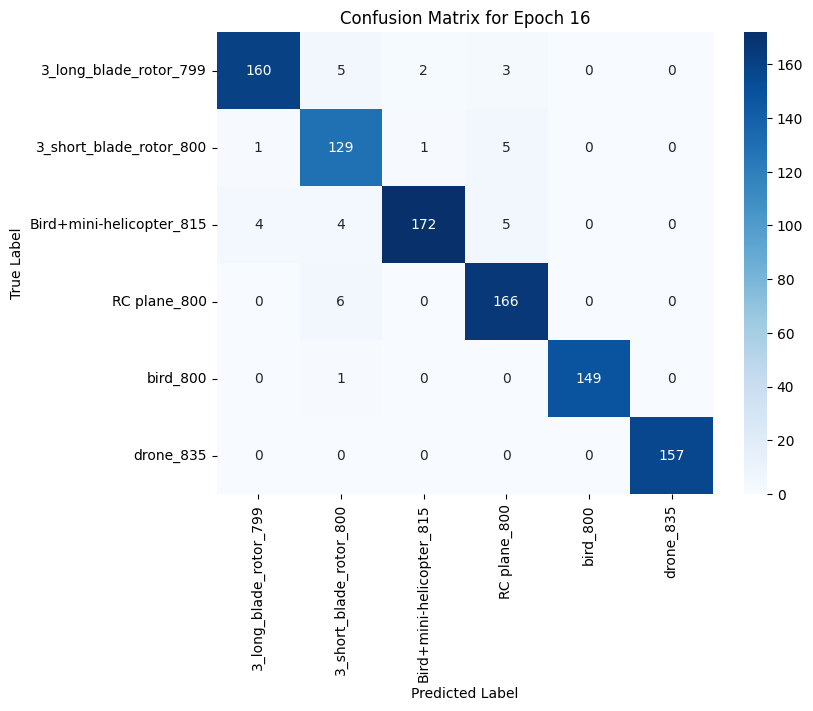

100%|██████████| 122/122 [01:09<00:00,  1.76it/s]


Epoch 17/50, Train Loss: 0.0046, Train Accuracy: 0.9557, Test Loss: 0.0038, Test Accuracy: 0.9649, Test Precision: 0.9656, Test Recall: 0.9649, Test F1: 0.9650, Test AUC: 0.9982


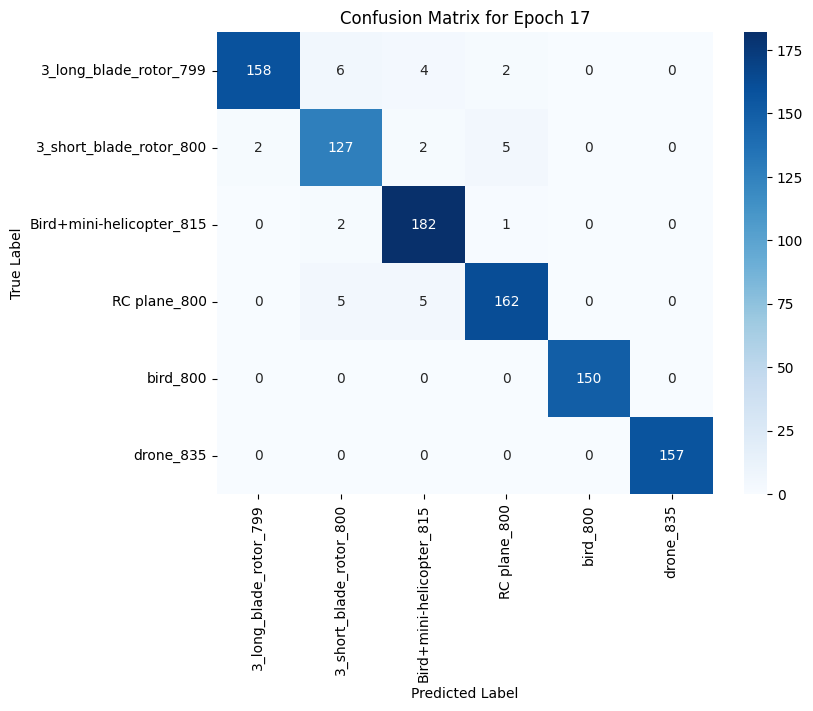

100%|██████████| 122/122 [01:08<00:00,  1.78it/s]


Epoch 18/50, Train Loss: 0.0056, Train Accuracy: 0.9410, Test Loss: 0.0046, Test Accuracy: 0.9515, Test Precision: 0.9540, Test Recall: 0.9515, Test F1: 0.9516, Test AUC: 0.9984


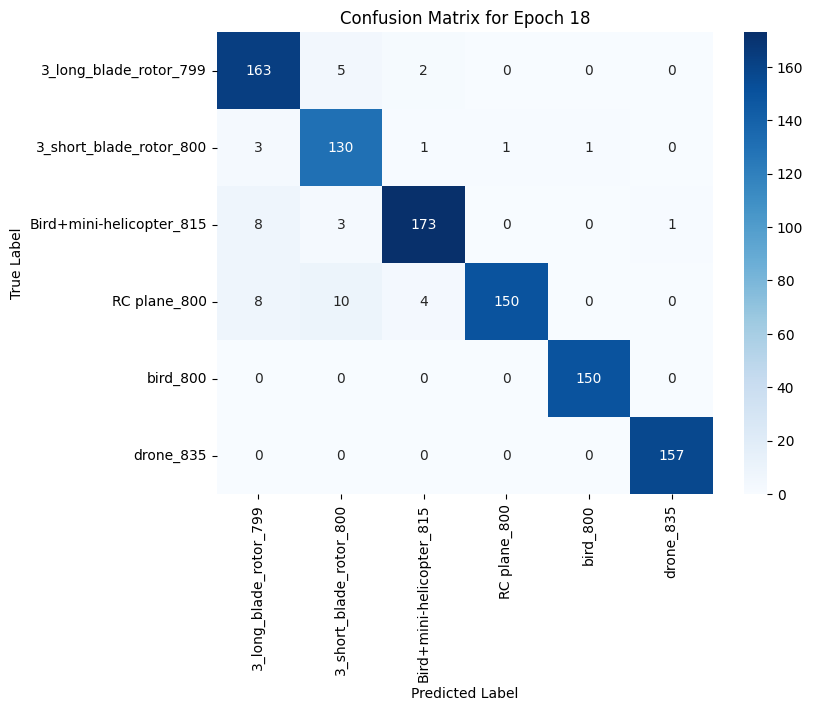

100%|██████████| 122/122 [01:08<00:00,  1.78it/s]


Epoch 19/50, Train Loss: 0.0028, Train Accuracy: 0.9683, Test Loss: 0.0045, Test Accuracy: 0.9639, Test Precision: 0.9656, Test Recall: 0.9639, Test F1: 0.9641, Test AUC: 0.9983


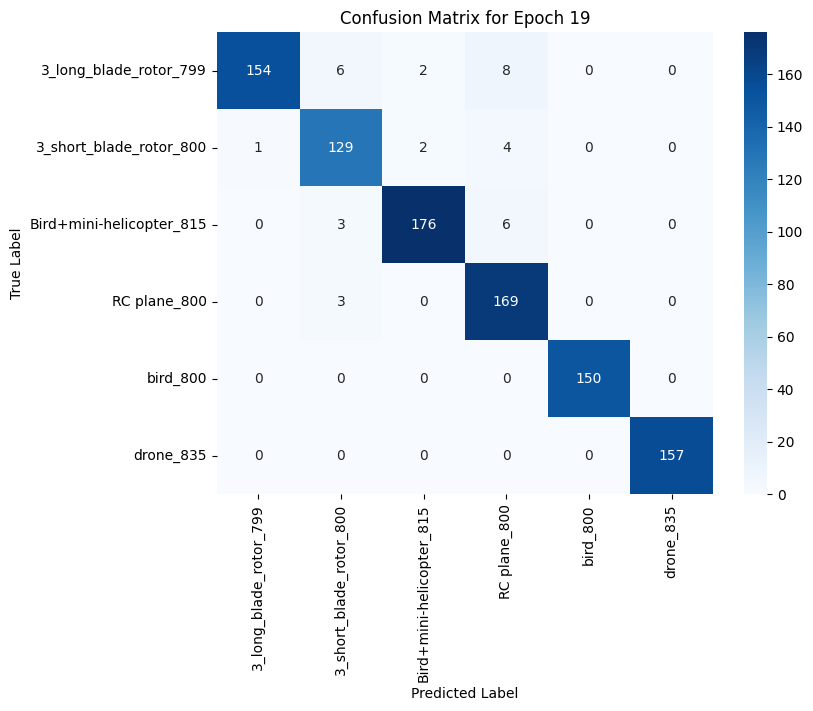

100%|██████████| 122/122 [01:08<00:00,  1.78it/s]


Epoch 20/50, Train Loss: 0.0036, Train Accuracy: 0.9611, Test Loss: 0.0037, Test Accuracy: 0.9598, Test Precision: 0.9611, Test Recall: 0.9598, Test F1: 0.9599, Test AUC: 0.9984


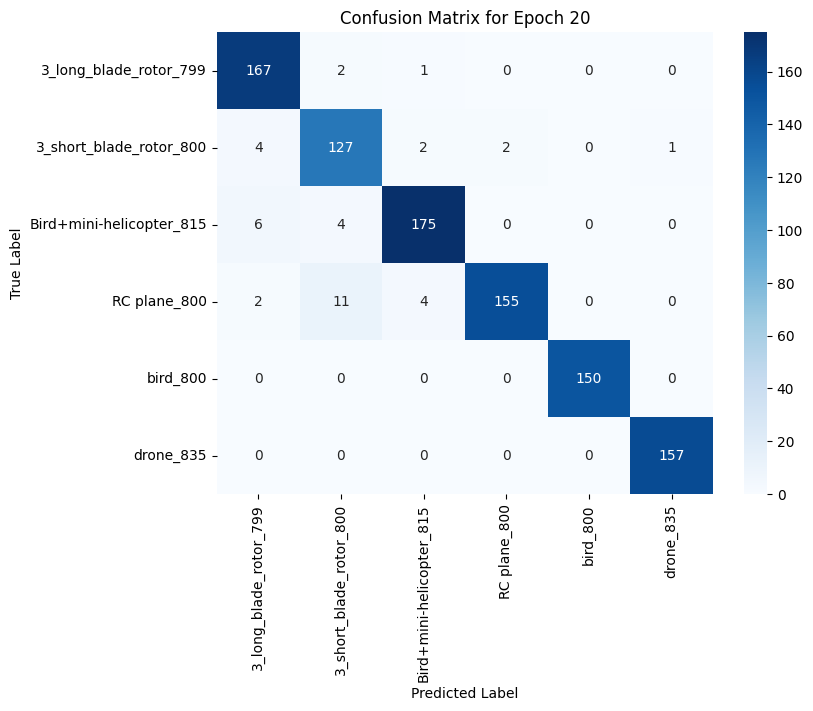

100%|██████████| 122/122 [01:08<00:00,  1.77it/s]


Epoch 21/50, Train Loss: 0.0028, Train Accuracy: 0.9675, Test Loss: 0.0031, Test Accuracy: 0.9722, Test Precision: 0.9725, Test Recall: 0.9722, Test F1: 0.9722, Test AUC: 0.9987


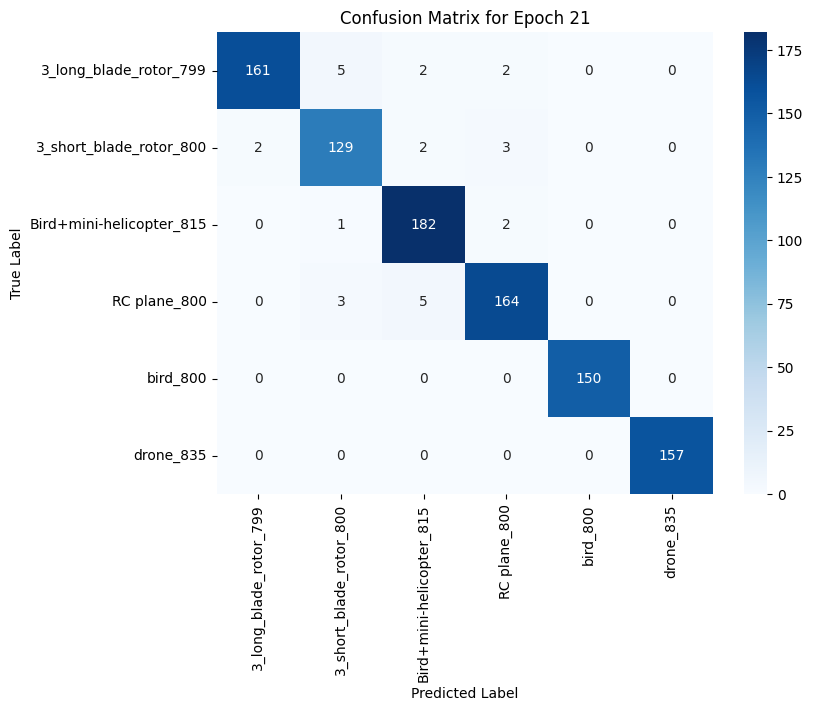

100%|██████████| 122/122 [01:08<00:00,  1.77it/s]


Epoch 22/50, Train Loss: 0.0019, Train Accuracy: 0.9783, Test Loss: 0.0034, Test Accuracy: 0.9670, Test Precision: 0.9672, Test Recall: 0.9670, Test F1: 0.9669, Test AUC: 0.9987


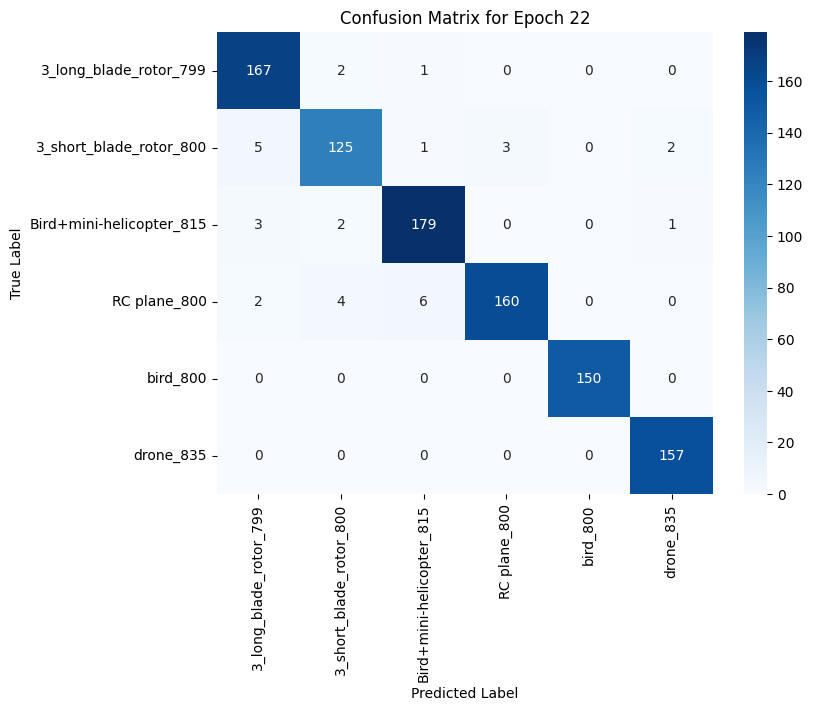

100%|██████████| 122/122 [01:08<00:00,  1.79it/s]


Epoch 23/50, Train Loss: 0.0024, Train Accuracy: 0.9719, Test Loss: 0.0040, Test Accuracy: 0.9619, Test Precision: 0.9634, Test Recall: 0.9619, Test F1: 0.9619, Test AUC: 0.9987


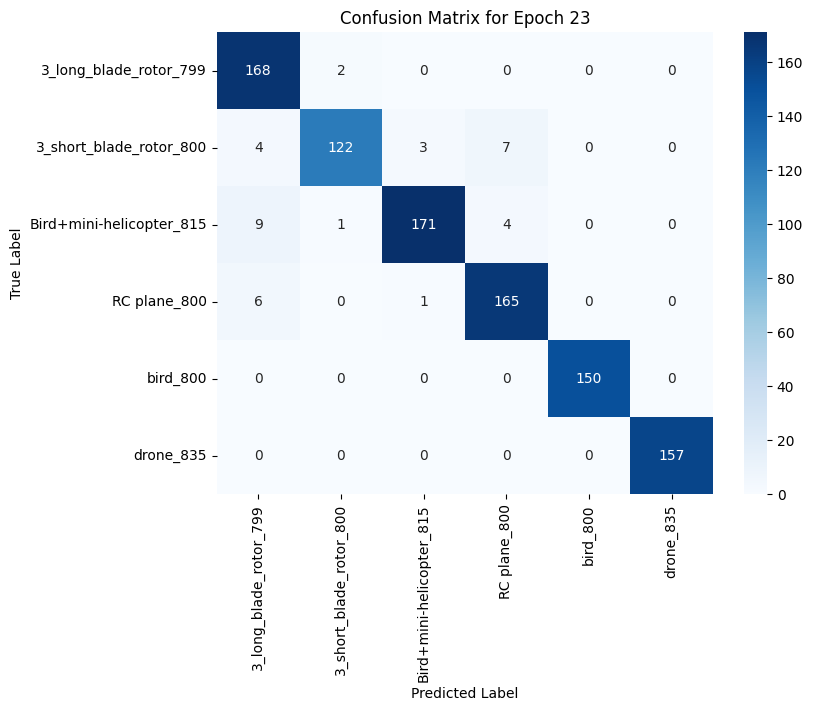

100%|██████████| 122/122 [01:08<00:00,  1.78it/s]


Epoch 24/50, Train Loss: 0.0024, Train Accuracy: 0.9732, Test Loss: 0.0050, Test Accuracy: 0.9526, Test Precision: 0.9544, Test Recall: 0.9526, Test F1: 0.9525, Test AUC: 0.9985


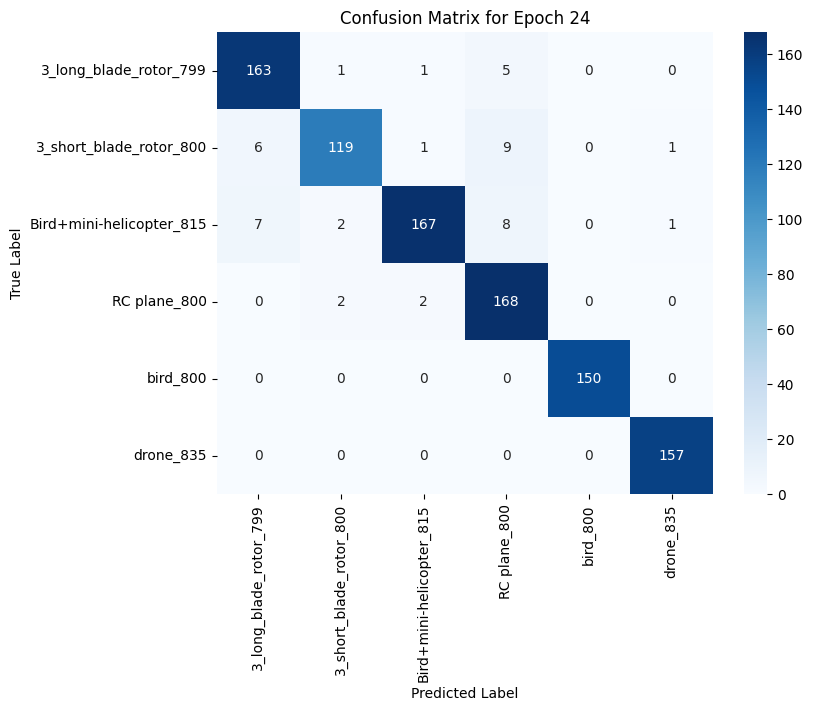

100%|██████████| 122/122 [01:08<00:00,  1.78it/s]


Epoch 25/50, Train Loss: 0.0024, Train Accuracy: 0.9729, Test Loss: 0.0052, Test Accuracy: 0.9515, Test Precision: 0.9553, Test Recall: 0.9515, Test F1: 0.9520, Test AUC: 0.9979


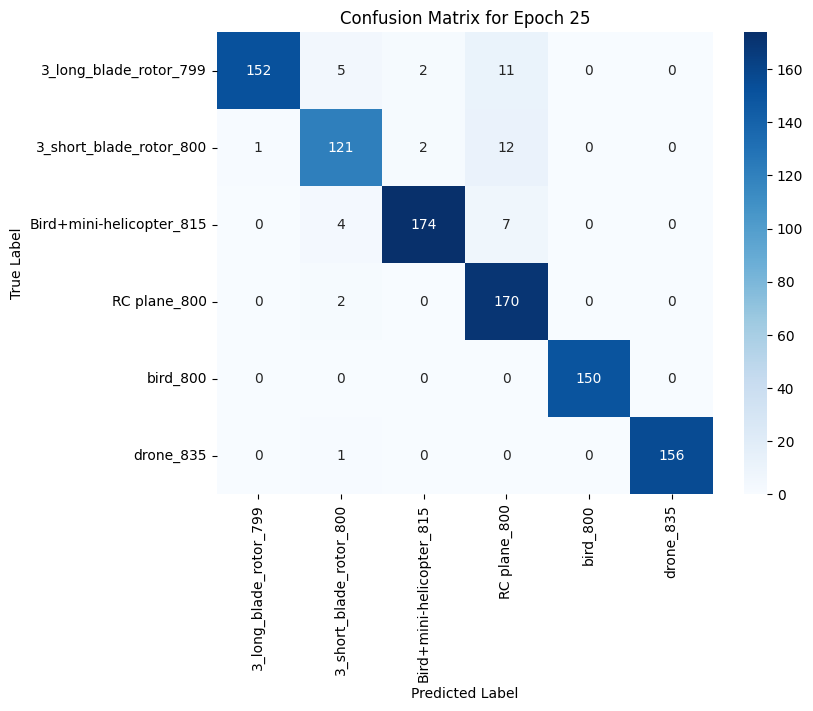

100%|██████████| 122/122 [01:09<00:00,  1.76it/s]


Epoch 26/50, Train Loss: 0.0025, Train Accuracy: 0.9701, Test Loss: 0.0034, Test Accuracy: 0.9691, Test Precision: 0.9695, Test Recall: 0.9691, Test F1: 0.9691, Test AUC: 0.9988


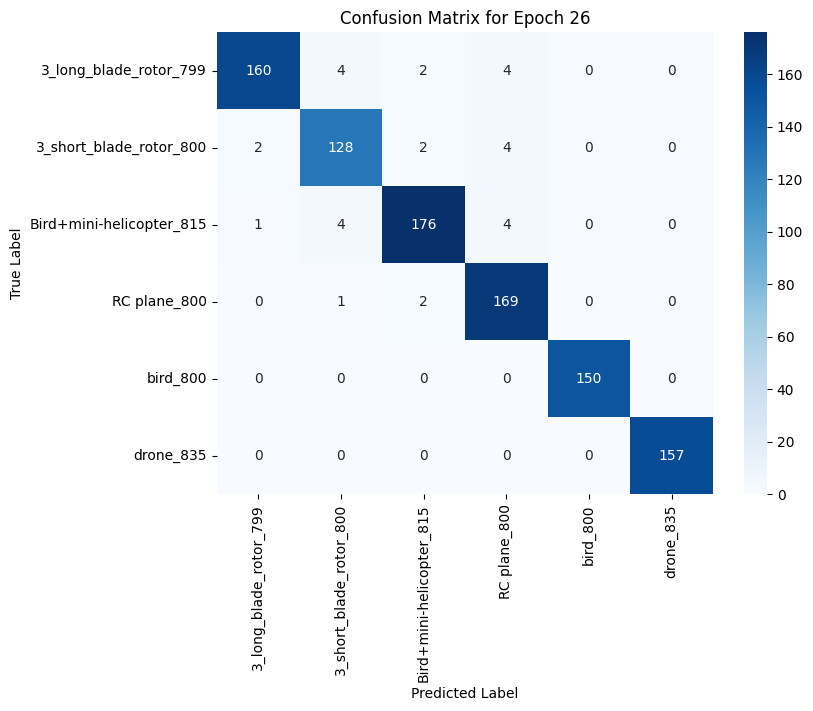

100%|██████████| 122/122 [01:09<00:00,  1.76it/s]


Epoch 27/50, Train Loss: 0.0025, Train Accuracy: 0.9734, Test Loss: 0.0056, Test Accuracy: 0.9588, Test Precision: 0.9617, Test Recall: 0.9588, Test F1: 0.9587, Test AUC: 0.9983


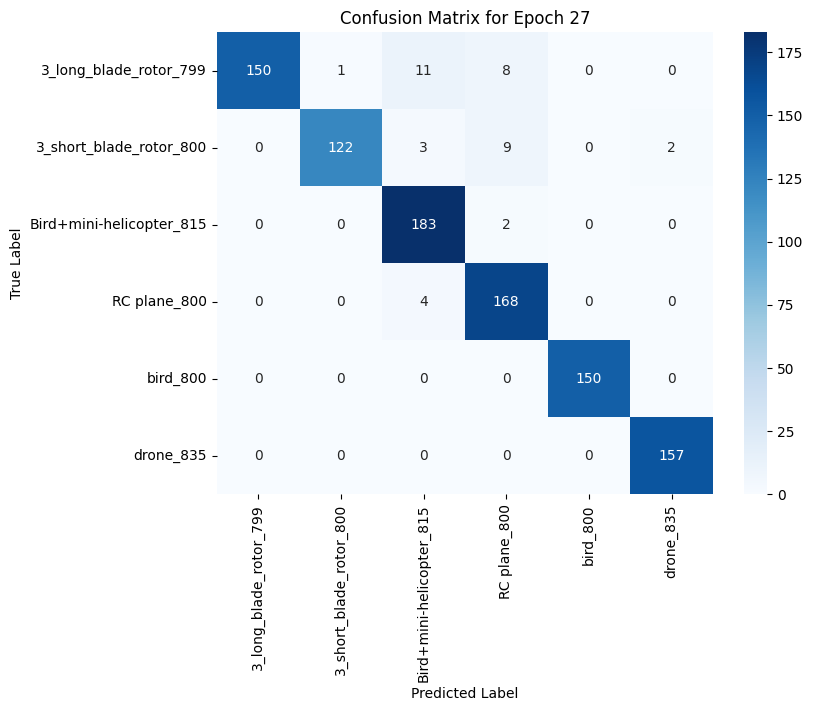

100%|██████████| 122/122 [01:08<00:00,  1.78it/s]


Epoch 28/50, Train Loss: 0.0019, Train Accuracy: 0.9804, Test Loss: 0.0034, Test Accuracy: 0.9722, Test Precision: 0.9727, Test Recall: 0.9722, Test F1: 0.9721, Test AUC: 0.9987


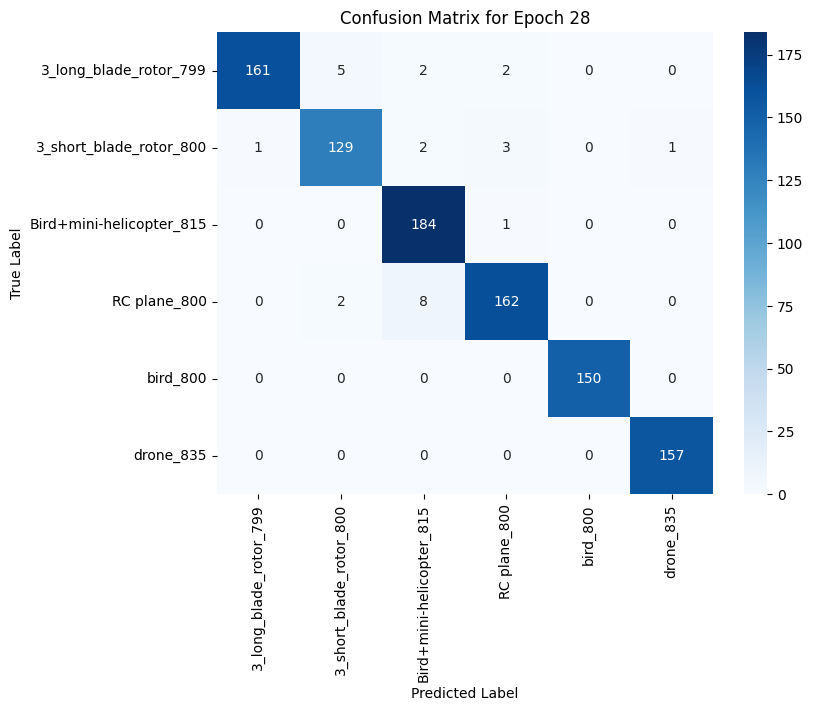

100%|██████████| 122/122 [01:08<00:00,  1.78it/s]


Epoch 29/50, Train Loss: 0.0025, Train Accuracy: 0.9729, Test Loss: 0.0121, Test Accuracy: 0.9072, Test Precision: 0.9235, Test Recall: 0.9072, Test F1: 0.8960, Test AUC: 0.9971


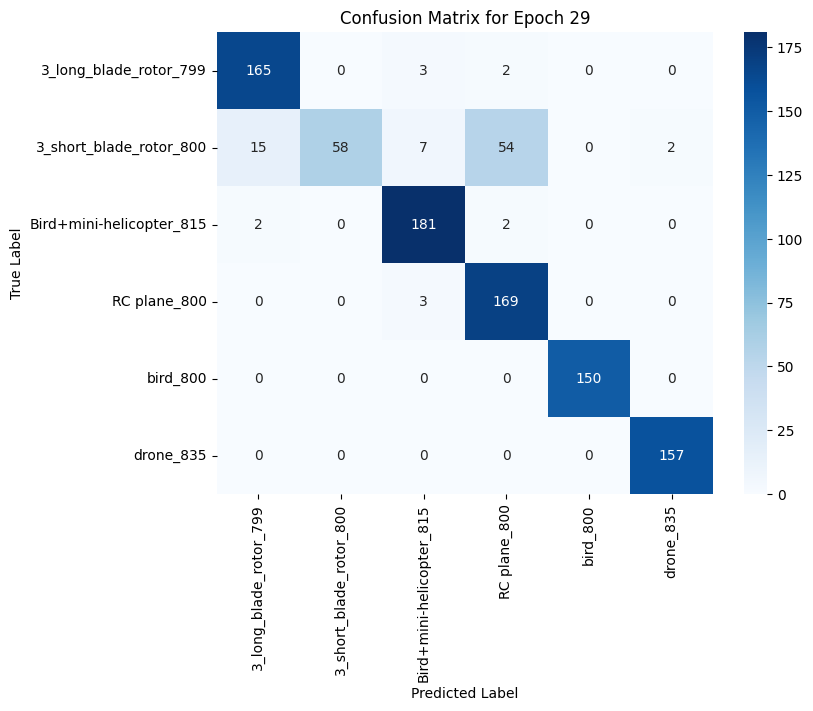

100%|██████████| 122/122 [01:09<00:00,  1.76it/s]


Epoch 30/50, Train Loss: 0.0030, Train Accuracy: 0.9685, Test Loss: 0.0043, Test Accuracy: 0.9536, Test Precision: 0.9558, Test Recall: 0.9536, Test F1: 0.9536, Test AUC: 0.9983


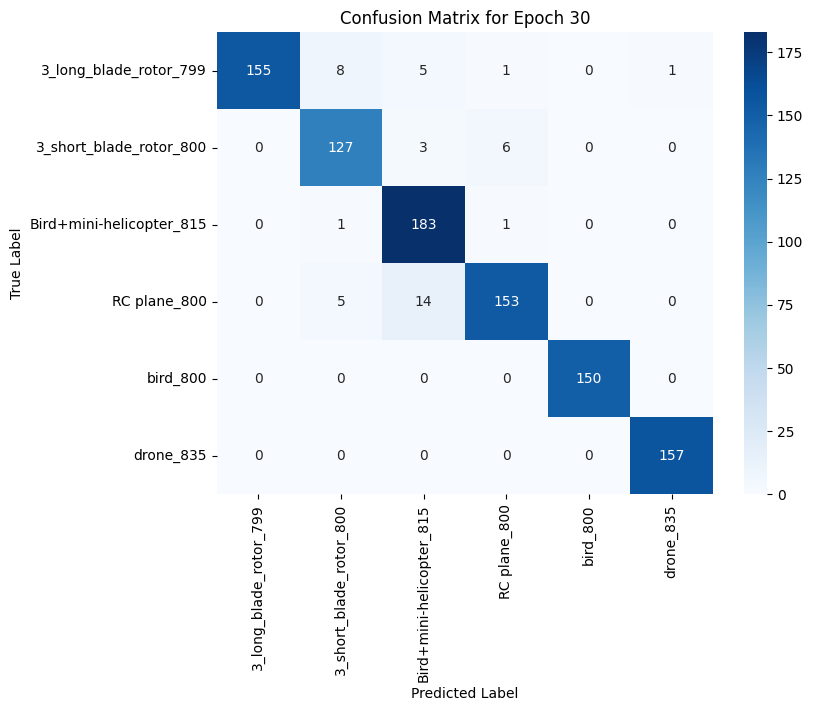

100%|██████████| 122/122 [01:09<00:00,  1.76it/s]


Epoch 31/50, Train Loss: 0.0020, Train Accuracy: 0.9801, Test Loss: 0.0032, Test Accuracy: 0.9773, Test Precision: 0.9775, Test Recall: 0.9773, Test F1: 0.9773, Test AUC: 0.9991


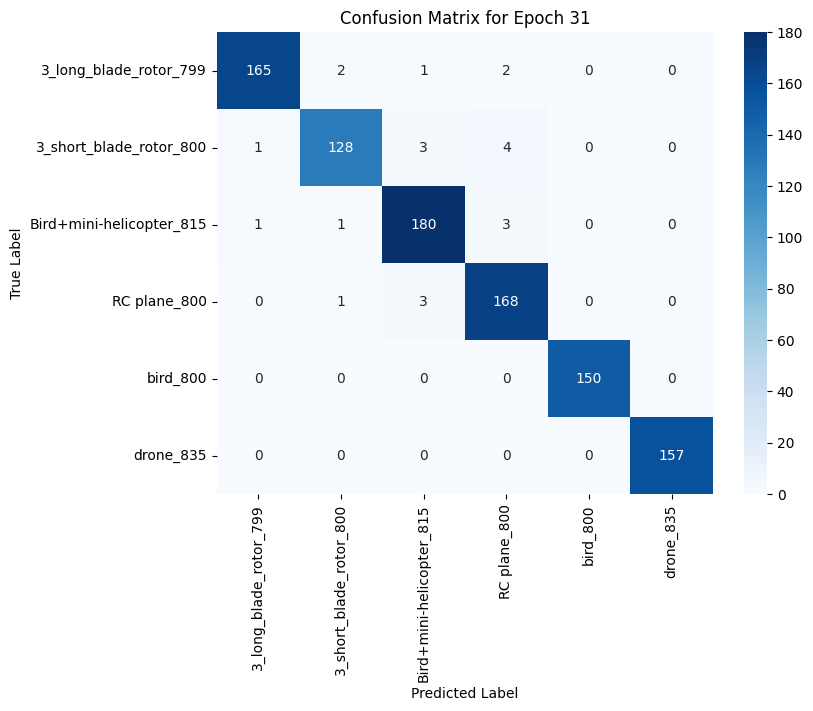

100%|██████████| 122/122 [01:08<00:00,  1.78it/s]


Epoch 32/50, Train Loss: 0.0014, Train Accuracy: 0.9838, Test Loss: 0.0029, Test Accuracy: 0.9691, Test Precision: 0.9699, Test Recall: 0.9691, Test F1: 0.9692, Test AUC: 0.9991


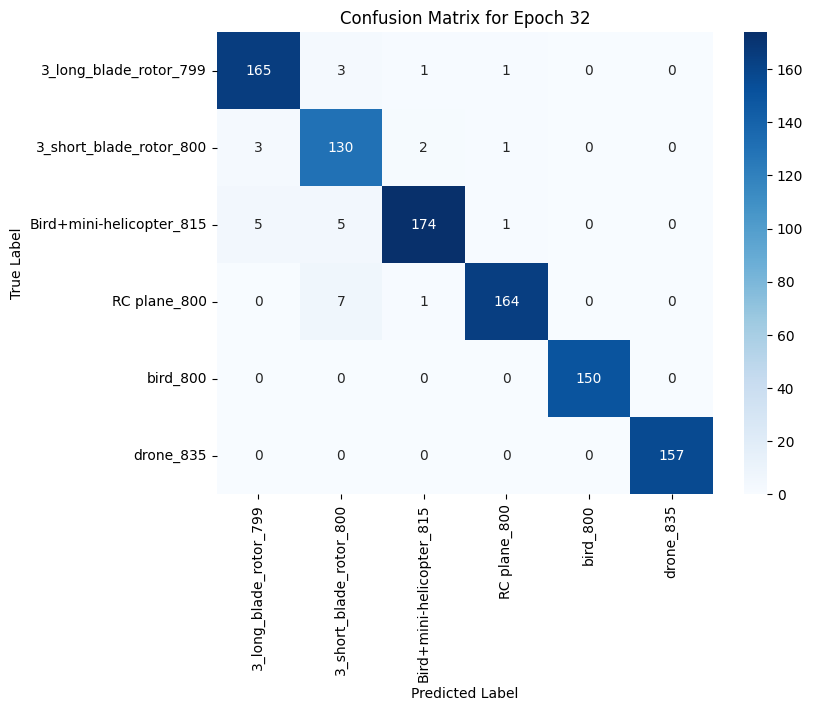

100%|██████████| 122/122 [01:07<00:00,  1.80it/s]


Epoch 33/50, Train Loss: 0.0013, Train Accuracy: 0.9858, Test Loss: 0.0025, Test Accuracy: 0.9784, Test Precision: 0.9788, Test Recall: 0.9784, Test F1: 0.9784, Test AUC: 0.9993


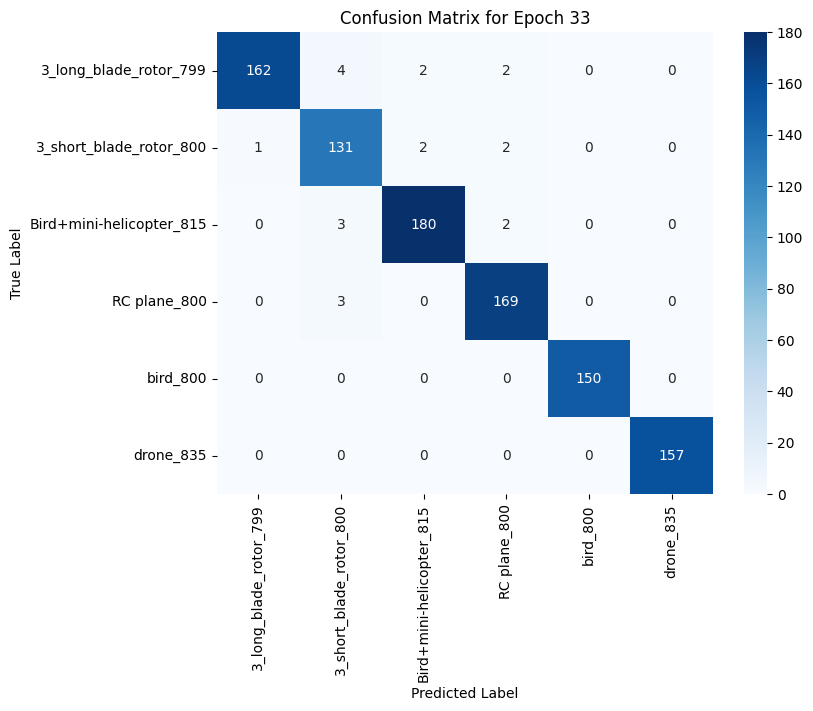

100%|██████████| 122/122 [01:08<00:00,  1.77it/s]


Epoch 34/50, Train Loss: 0.0015, Train Accuracy: 0.9838, Test Loss: 0.0050, Test Accuracy: 0.9505, Test Precision: 0.9587, Test Recall: 0.9505, Test F1: 0.9521, Test AUC: 0.9985


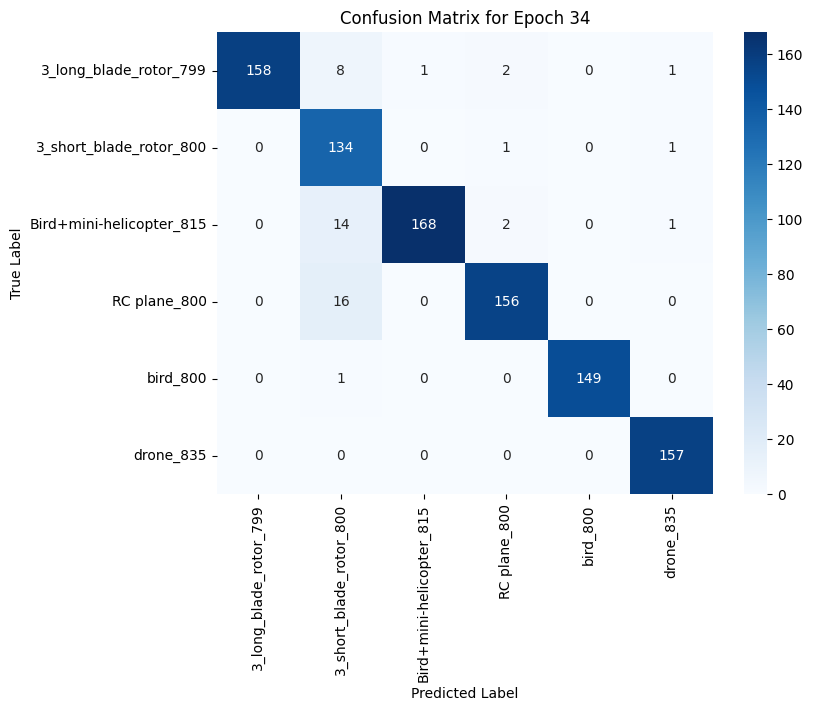

100%|██████████| 122/122 [01:08<00:00,  1.77it/s]


Epoch 35/50, Train Loss: 0.0019, Train Accuracy: 0.9760, Test Loss: 0.0023, Test Accuracy: 0.9784, Test Precision: 0.9786, Test Recall: 0.9784, Test F1: 0.9784, Test AUC: 0.9994


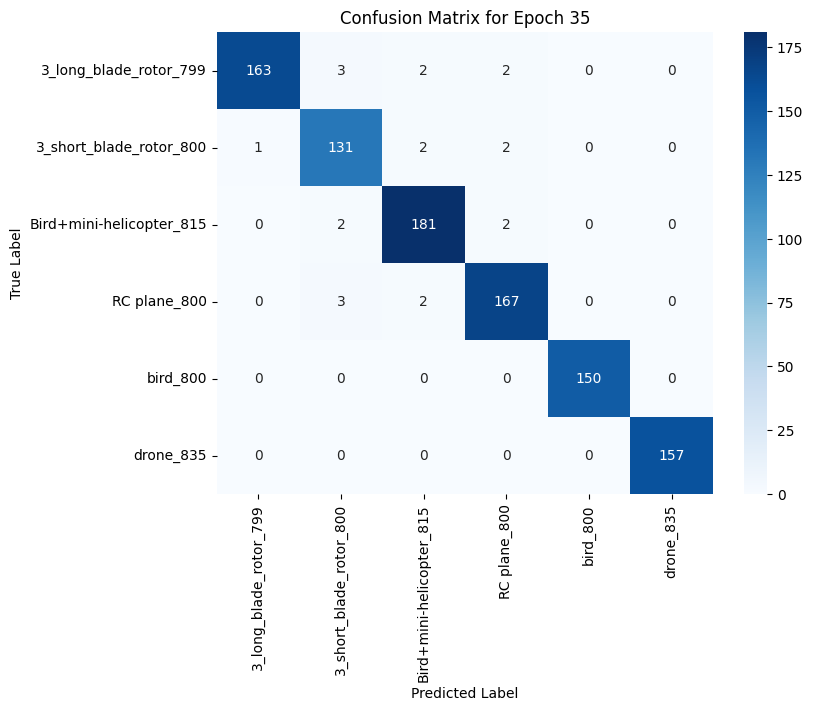

100%|██████████| 122/122 [01:08<00:00,  1.78it/s]


Epoch 36/50, Train Loss: 0.0028, Train Accuracy: 0.9719, Test Loss: 0.0032, Test Accuracy: 0.9711, Test Precision: 0.9719, Test Recall: 0.9711, Test F1: 0.9711, Test AUC: 0.9993


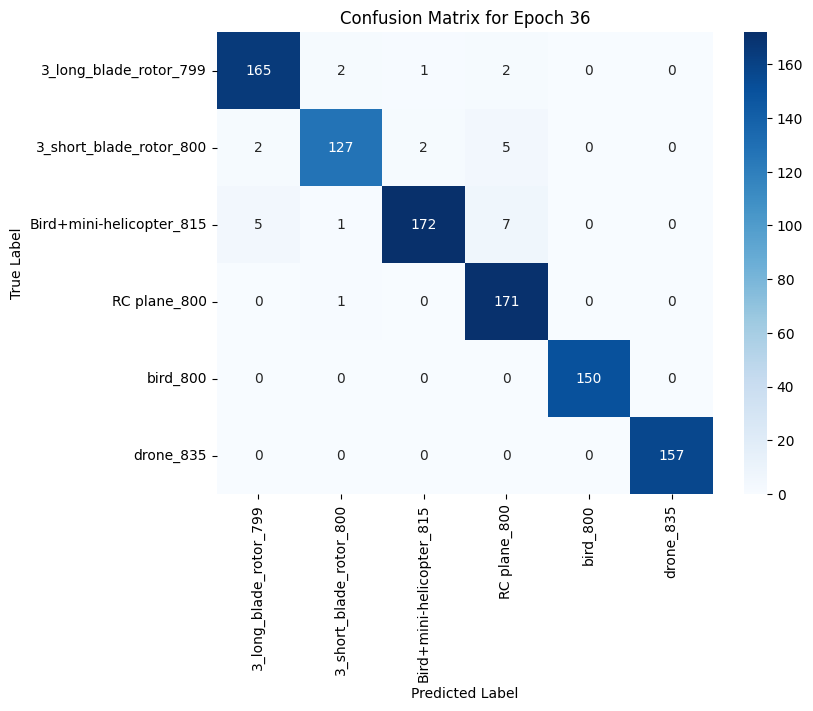

100%|██████████| 122/122 [01:08<00:00,  1.79it/s]


Epoch 37/50, Train Loss: 0.0024, Train Accuracy: 0.9742, Test Loss: 0.0046, Test Accuracy: 0.9680, Test Precision: 0.9683, Test Recall: 0.9680, Test F1: 0.9679, Test AUC: 0.9980


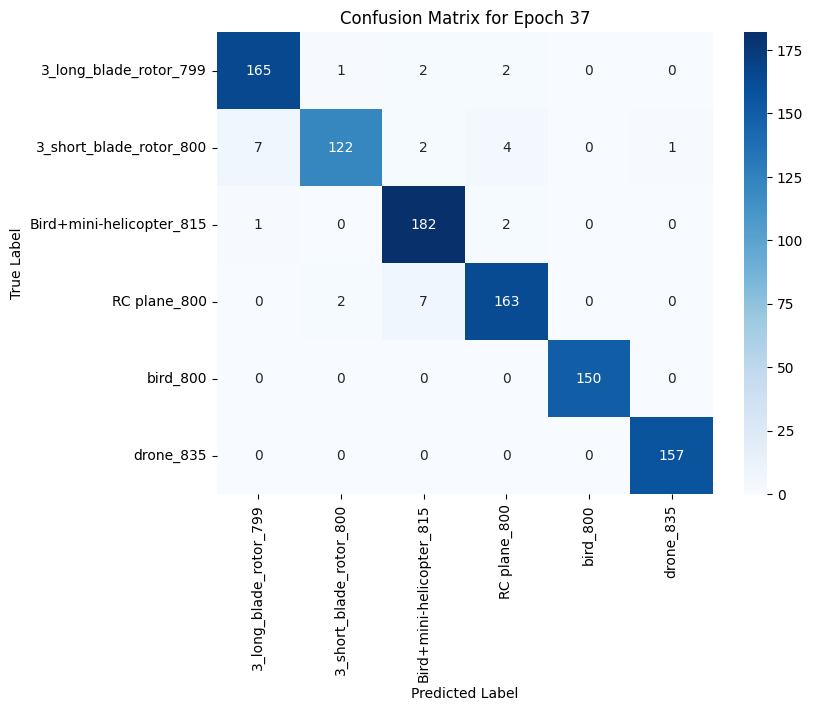

100%|██████████| 122/122 [01:08<00:00,  1.77it/s]


Epoch 38/50, Train Loss: 0.0017, Train Accuracy: 0.9812, Test Loss: 0.0041, Test Accuracy: 0.9619, Test Precision: 0.9640, Test Recall: 0.9619, Test F1: 0.9619, Test AUC: 0.9987


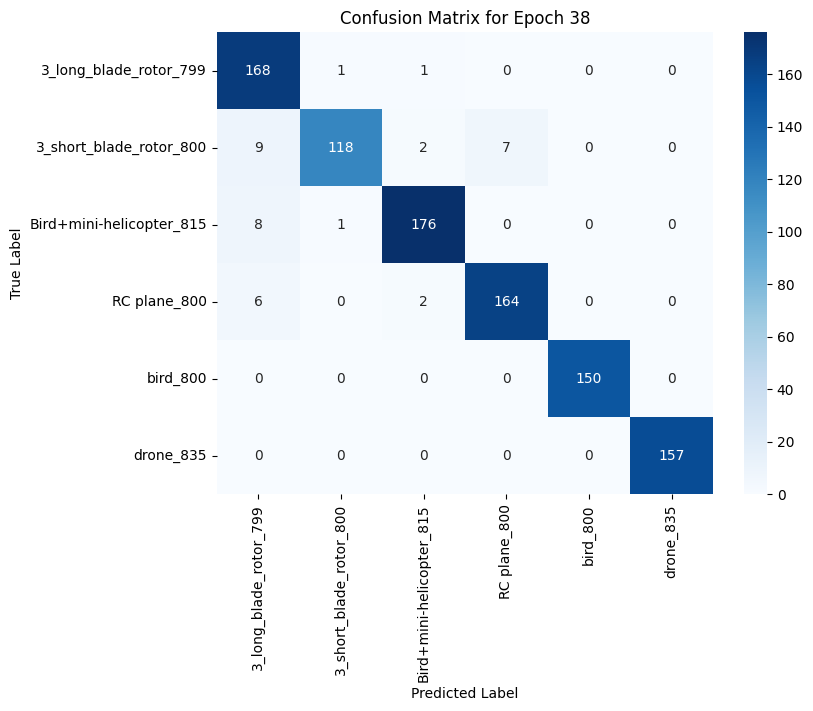

100%|██████████| 122/122 [01:09<00:00,  1.77it/s]


Epoch 39/50, Train Loss: 0.0019, Train Accuracy: 0.9786, Test Loss: 0.0029, Test Accuracy: 0.9722, Test Precision: 0.9725, Test Recall: 0.9722, Test F1: 0.9722, Test AUC: 0.9992


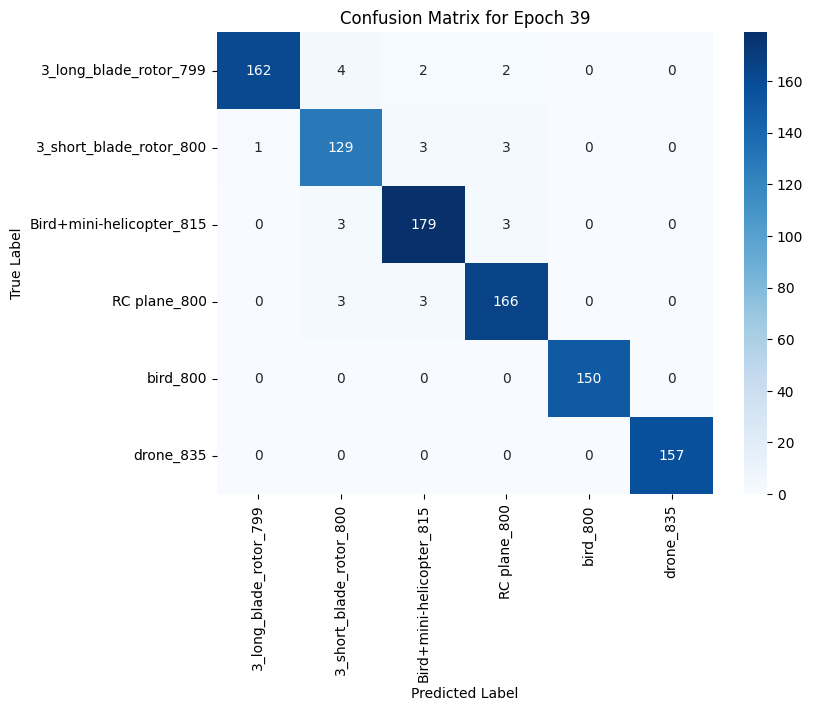

100%|██████████| 122/122 [01:09<00:00,  1.76it/s]


Epoch 40/50, Train Loss: 0.0008, Train Accuracy: 0.9902, Test Loss: 0.0038, Test Accuracy: 0.9722, Test Precision: 0.9732, Test Recall: 0.9722, Test F1: 0.9723, Test AUC: 0.9991


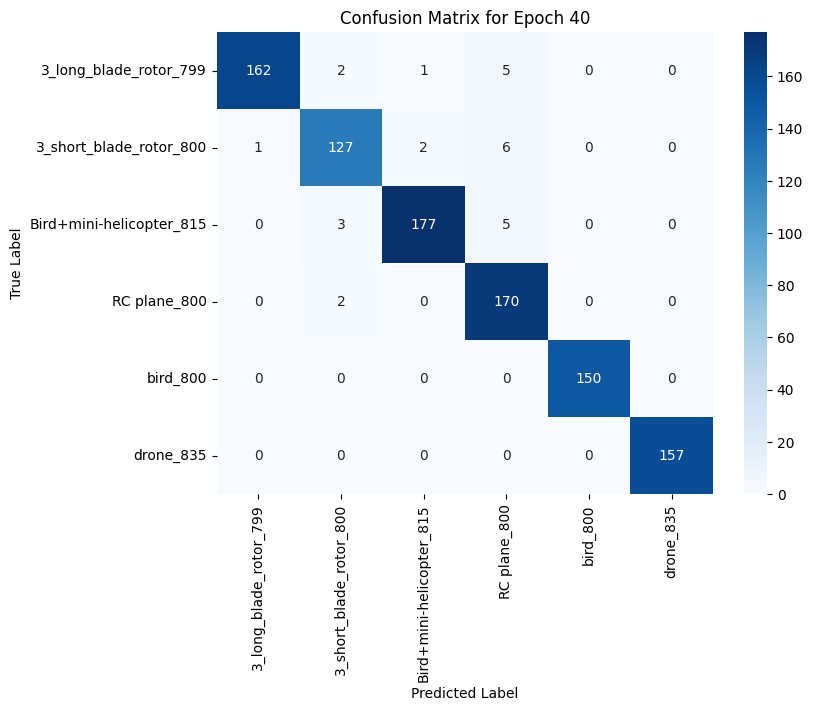

100%|██████████| 122/122 [01:09<00:00,  1.75it/s]


Epoch 41/50, Train Loss: 0.0013, Train Accuracy: 0.9832, Test Loss: 0.0036, Test Accuracy: 0.9639, Test Precision: 0.9654, Test Recall: 0.9639, Test F1: 0.9639, Test AUC: 0.9989


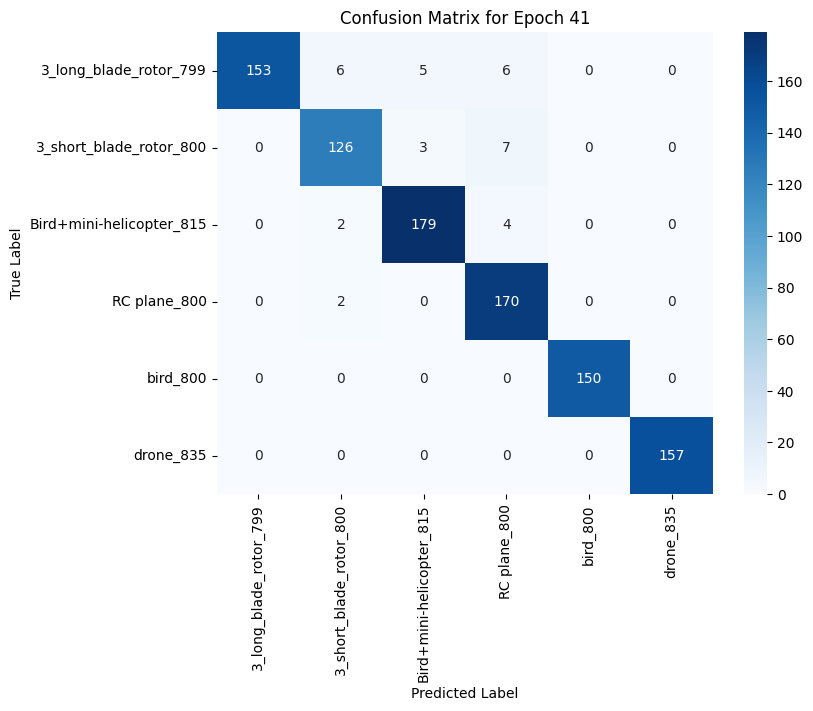

100%|██████████| 122/122 [01:09<00:00,  1.76it/s]


Epoch 42/50, Train Loss: 0.0013, Train Accuracy: 0.9832, Test Loss: 0.0042, Test Accuracy: 0.9670, Test Precision: 0.9670, Test Recall: 0.9670, Test F1: 0.9667, Test AUC: 0.9987


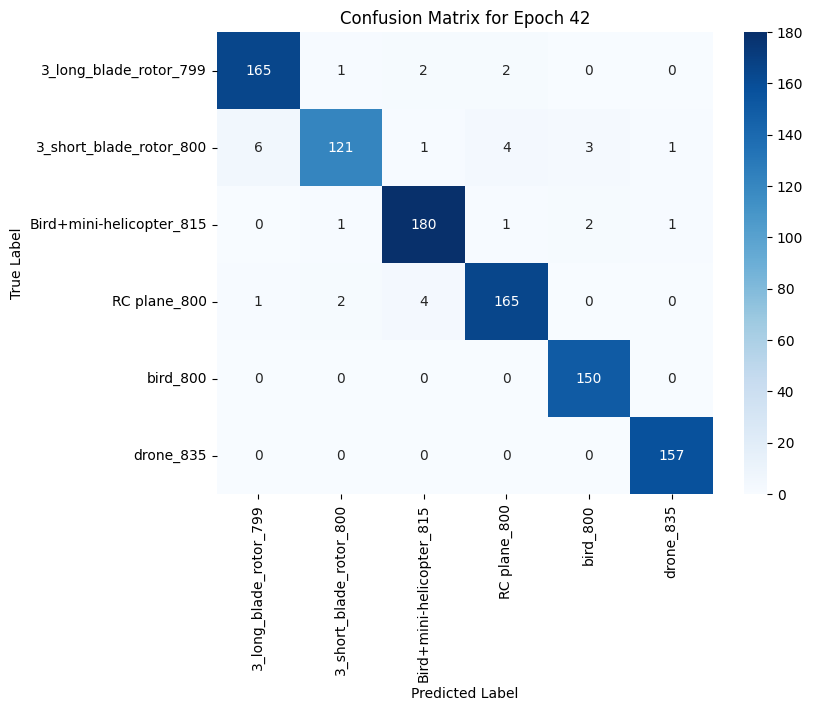

100%|██████████| 122/122 [01:08<00:00,  1.77it/s]


Epoch 43/50, Train Loss: 0.0019, Train Accuracy: 0.9778, Test Loss: 0.0034, Test Accuracy: 0.9742, Test Precision: 0.9746, Test Recall: 0.9742, Test F1: 0.9742, Test AUC: 0.9992


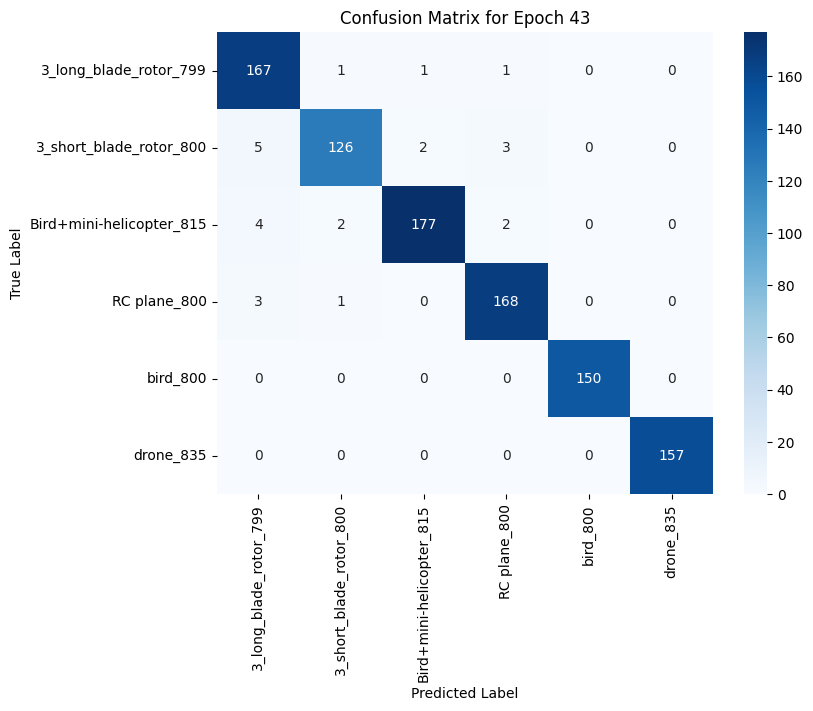

100%|██████████| 122/122 [01:08<00:00,  1.79it/s]


Epoch 44/50, Train Loss: 0.0009, Train Accuracy: 0.9910, Test Loss: 0.0030, Test Accuracy: 0.9753, Test Precision: 0.9757, Test Recall: 0.9753, Test F1: 0.9753, Test AUC: 0.9991


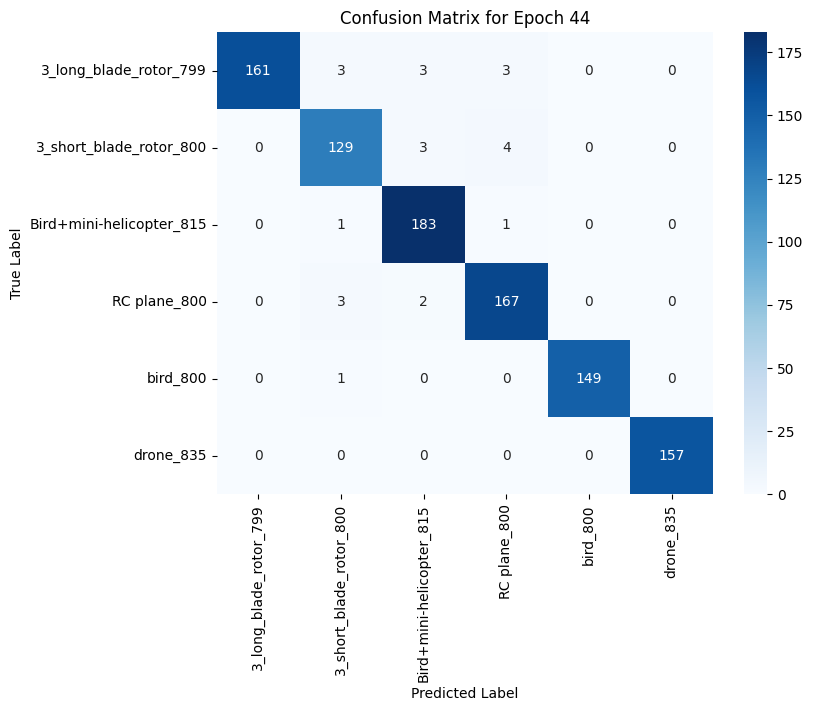

100%|██████████| 122/122 [01:10<00:00,  1.73it/s]


Epoch 45/50, Train Loss: 0.0012, Train Accuracy: 0.9879, Test Loss: 0.0039, Test Accuracy: 0.9577, Test Precision: 0.9591, Test Recall: 0.9577, Test F1: 0.9578, Test AUC: 0.9986


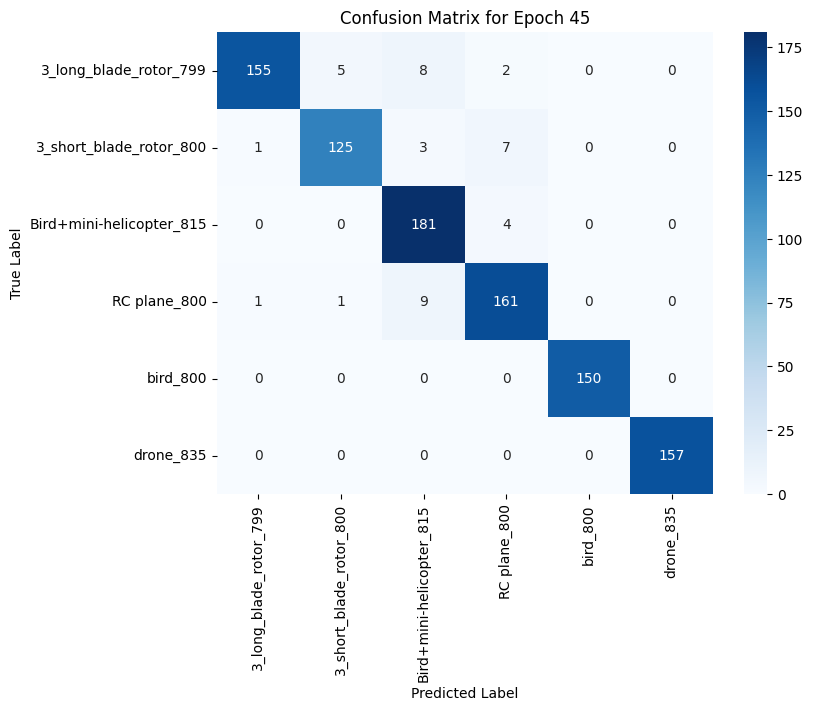

100%|██████████| 122/122 [01:09<00:00,  1.76it/s]


Epoch 46/50, Train Loss: 0.0013, Train Accuracy: 0.9856, Test Loss: 0.0025, Test Accuracy: 0.9763, Test Precision: 0.9764, Test Recall: 0.9763, Test F1: 0.9763, Test AUC: 0.9991


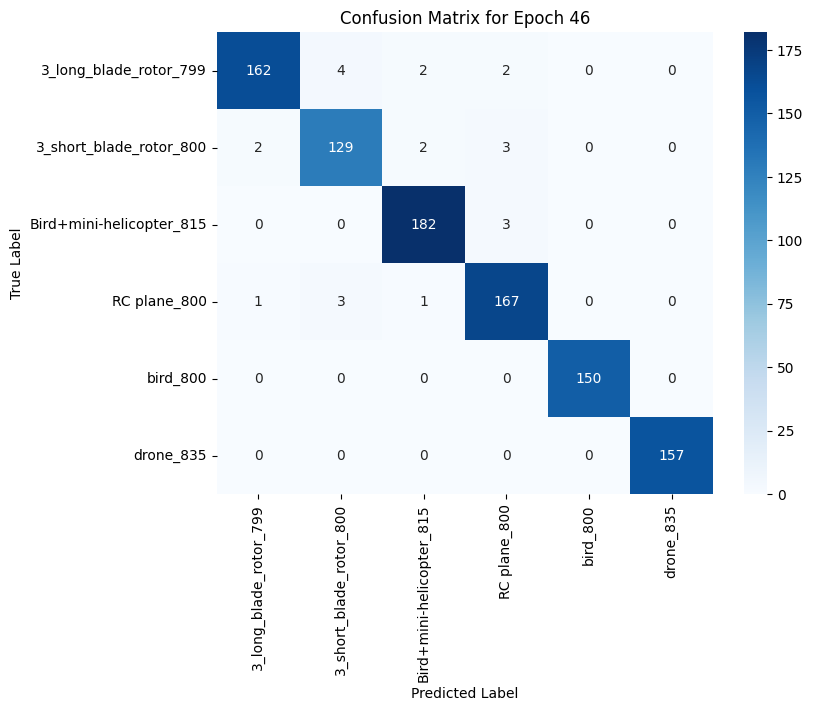

100%|██████████| 122/122 [01:08<00:00,  1.77it/s]


Epoch 47/50, Train Loss: 0.0010, Train Accuracy: 0.9884, Test Loss: 0.0021, Test Accuracy: 0.9814, Test Precision: 0.9816, Test Recall: 0.9814, Test F1: 0.9814, Test AUC: 0.9994


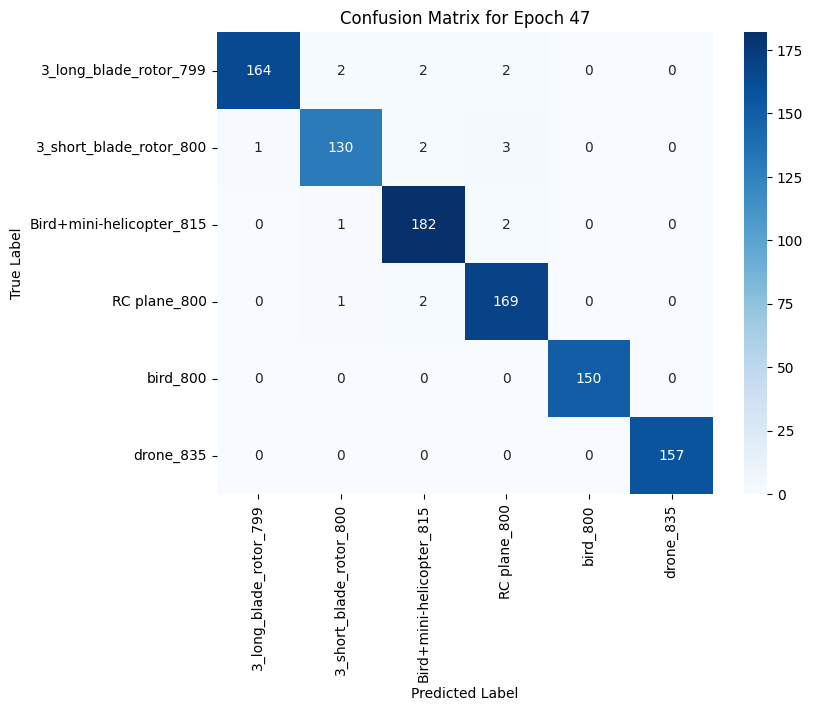

100%|██████████| 122/122 [01:08<00:00,  1.78it/s]


Epoch 48/50, Train Loss: 0.0005, Train Accuracy: 0.9951, Test Loss: 0.0040, Test Accuracy: 0.9691, Test Precision: 0.9702, Test Recall: 0.9691, Test F1: 0.9688, Test AUC: 0.9988


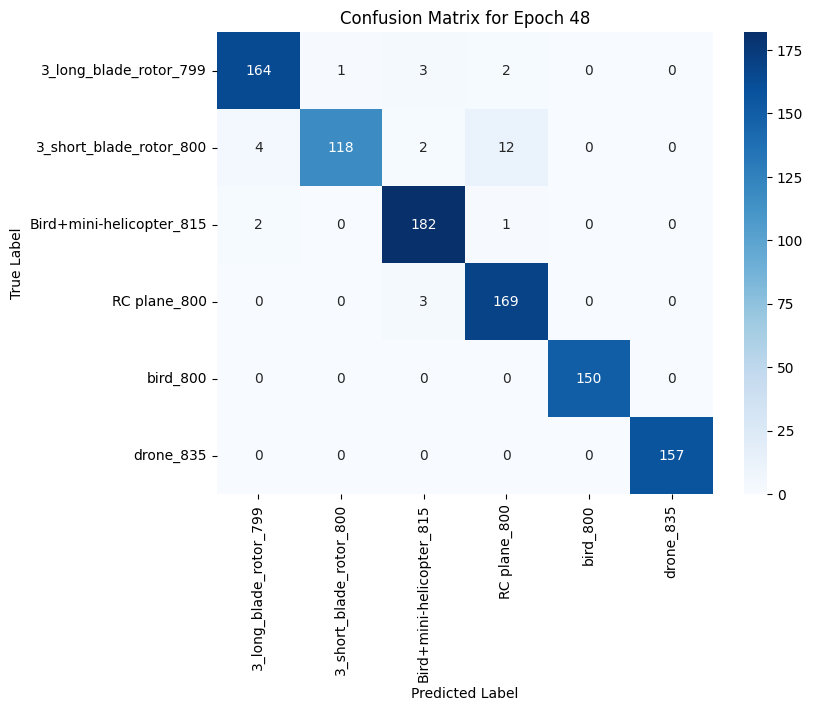

100%|██████████| 122/122 [01:08<00:00,  1.77it/s]


Epoch 49/50, Train Loss: 0.0011, Train Accuracy: 0.9874, Test Loss: 0.0055, Test Accuracy: 0.9381, Test Precision: 0.9504, Test Recall: 0.9381, Test F1: 0.9383, Test AUC: 0.9989


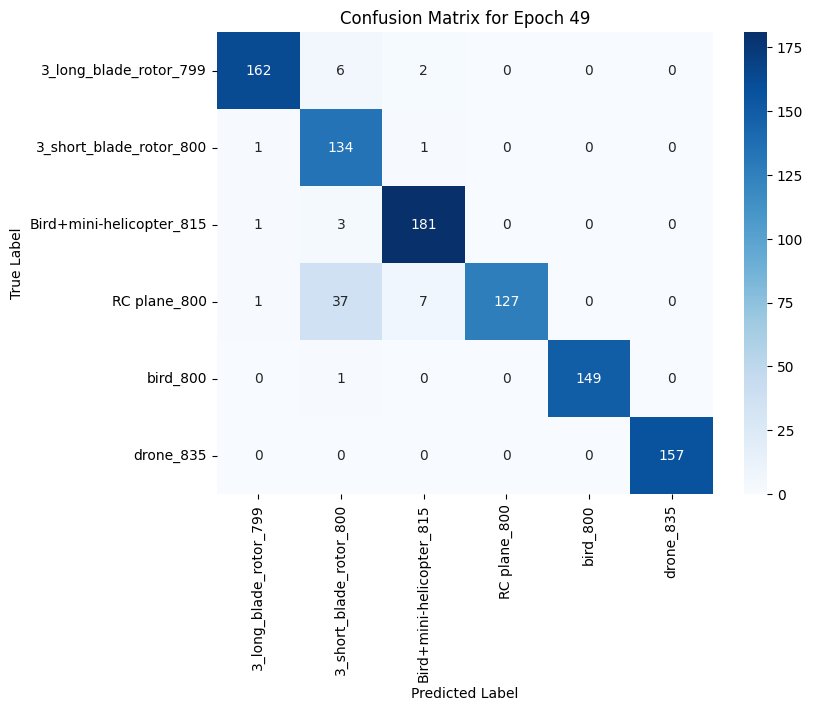

100%|██████████| 122/122 [01:08<00:00,  1.78it/s]


Epoch 50/50, Train Loss: 0.0009, Train Accuracy: 0.9910, Test Loss: 0.0031, Test Accuracy: 0.9753, Test Precision: 0.9758, Test Recall: 0.9753, Test F1: 0.9751, Test AUC: 0.9993


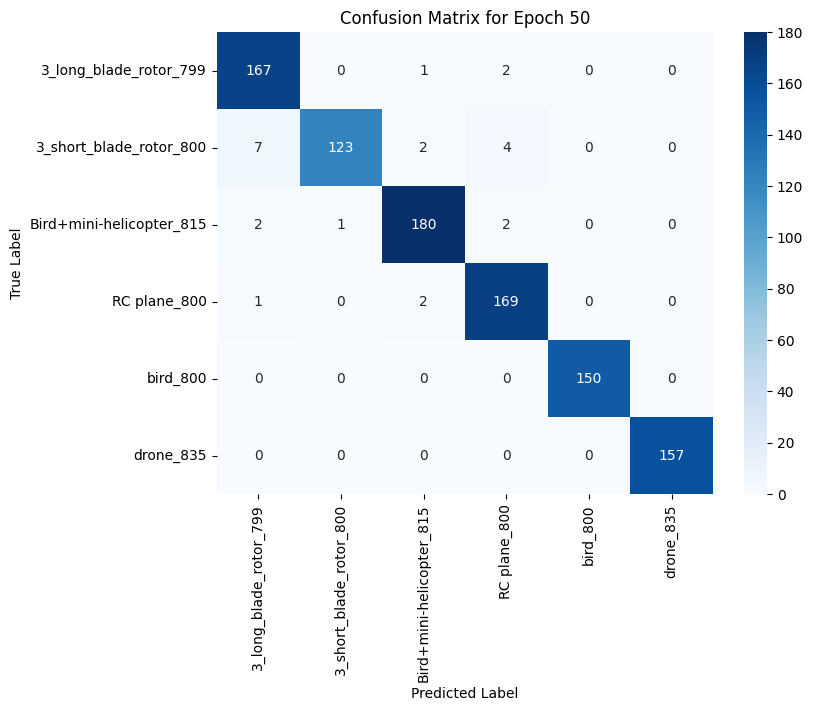

In [ ]:
# Start training
train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs=50, device=device)